In [7]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python.retinotopy import utils as retutils
from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils
from pipeline.python.classifications import decode_by_ncells as dc

In [2]:
%matplotlib notebook

In [3]:
n_iterations=100
overlap_thr=0.
n_processes=1
responsive_test='nstds'
responsive_thr=10.
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10

# CV stuff
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)

stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'

do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=0.0, C=None


In [4]:
train_str = 'traintest_by-fov_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()

#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')
decoding_dir = os.path.join(aggregate_dir, 'decoding')

# Create data ID for labeling figures with data-types
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)

traces001|filter_None_blobsonly|dff_nstds-thr-10.00


# Set ouptut dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Individual FOVs

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['visual_area'].unique()

Segmentation: missing 9 dsets


array([u'Li', u'Ll', u'Lm', u'V1'], dtype=object)

In [16]:
def load_fov_results(animalid, session, fov, traceid='traces001', prefix='by_fov', 
                     visual_area=None, C_value=None, response_type='dff', 
                    responsive_test='nstds', trial_epoch='stimulus', overlap_thr=None, has_retino=False):

    # Get result ID
    results_id = dc.create_results_id(prefix=analysis_type, visual_area=visual_area, 
                                  C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                  trial_epoch=trial_epoch, overlap_thr=overlap_thr, has_retino=has_retino)
    # Load FOV results
    iterdf = dc.load_decode_within_fov(animalid, session, fov, traceid=traceid, results_id=results_id)
    
    return iterdf, results_id



In [19]:
split_pupil=False
C_value=None
trial_epoch='plushalf'
overlap_thr=0

animalid='JC097'
session = '20190617'
fov='FOV1_zoom2p0x'
visual_area = 'V1'
analysis_type = 'split_pupil' if split_pupil else 'by_fov'
#results_prefix = analysis_type

# Get result ID
iterdf, results_id = load_fov_results(animalid, session, fov, traceid=traceid, prefix=analysis_type, visual_area=visual_area, 
                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                            trial_epoch=trial_epoch, overlap_thr=None, has_retino=False)
print(results_id, iterdf.shape)

iterdf.groupby(['condition']).mean().reset_index()

('by_fov_V1__dff-nstds_overlap0.0__plushalf__tuneC', (200, 15))
('by_fov_V1__dff-nstds_retino__plushalf__tuneC', (200, 15))


# Load all data

In [32]:
curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'

#### Load neural responses
analysis_type='by_fov'

trial_epoch='plushalf'
responsive_test='nstds' #'roc'
responsive_thr=10. #0.05
response_type='dff'

# match_distns=False
# overlap_thr=0.0
# has_rfs = overlap_thr is not None
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li', 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=True, zscore_now=True,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()


Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum
visual_area                                                
Li           1142  1142      1142     1142     1142    1142
Ll            293   293       293      293      293     293
Lm           1970  1970      1970     1970     1970    1970
V1           2089  2089      2089     2089     2089    2089

#### 1. Compare filter methods

In [37]:
i_=[]
for (visual_area, animalid, session, fov, datakey), g in all_cells.groupby(['visual_area', 'animalid', 'session', 'fov', 'datakey']):
    iterdf_rf, results_id_rf = load_fov_results(animalid, session, fov, traceid=traceid, prefix=analysis_type, visual_area=visual_area, 
                                C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                trial_epoch=trial_epoch, overlap_thr=0.0, has_retino=False)
    iterdf_ret, results_id_ret = load_fov_results(animalid, session, fov, traceid=traceid, prefix=analysis_type, visual_area=visual_area, 
                                C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                                trial_epoch=trial_epoch, overlap_thr=None, has_retino=True)
    if iterdf_rf is None and iterdf_ret is None:
        print("(%s, %s) None" % (visual_area, datakey))
        continue
        
    if iterdf_rf is None:
        print("(%s, %s) No RF" % (visual_area, datakey))
    else:
        iterdf_rf['filter'] = 'rf'
    if iterdf_ret is None:
        print("(%s, %s) No retino" % (visual_area, datakey))
    else:
        iterdf_ret['filter'] = 'retino'

    iterd = pd.concat([iterdf_rf, iterdf_ret], axis=0).reset_index(drop=True)
    iterd['visual_area'] = visual_area
    iterd['datakey'] = datakey
    i_.append(iterd)



(Li, 20190319_JC067_fov1) No RF
(Li, 20190320_JC067_fov1) None
(Li, 20190314_JC070_fov1) None
(Li, 20190315_JC070_fov1) No RF
(Li, 20190316_JC070_fov1) No RF
(Li, 20190321_JC070_fov1) No RF
(Li, 20190322_JC073_fov1) No RF
(Li, 20190327_JC073_fov1) None
(Li, 20190422_JC076_fov1) None
(Li, 20190617_JC099_fov1) None
(Li, 20191018_JC113_fov1) No retino
(Li, 20191111_JC120_fov1) None
(Ll, 20190319_JC067_fov1) No RF
(Ll, 20190320_JC067_fov1) No RF
(Ll, 20190612_JC099_fov1) No RF
(Lm, 20190306_JC061_fov3) No RF
(Lm, 20190322_JC073_fov1) No RF
(Lm, 20190327_JC073_fov1) None
(Lm, 20190509_JC078_fov1) No RF
(Lm, 20191111_JC120_fov1) None
(V1, 20190504_JC078_fov1) No RF
(V1, 20190509_JC078_fov1) No RF
(V1, 20190517_JC083_fov1) None
(V1, 20191006_JC110_fov1) No retino


In [39]:
iterd = pd.concat(i_, axis=0).reset_index(drop=True)
iterd.groupby(['condition', 'visual_area', 'filter']).mean().reset_index()


condition visual_area  filter          C  fit_time  heldout_MI  \
0       data          Li  retino  22.645041  0.115570    0.026868   
1       data          Li      rf  17.868790  0.105205    0.054828   
2       data          Ll  retino  43.608130  0.417836    0.010014   
3       data          Lm  retino  29.317079  0.399520    0.024858   
4       data          Lm      rf  16.371885  0.166225    0.043053   
5       data          V1  retino  18.925461  0.070060    0.082260   
6       data          V1      rf  10.953148  0.046824    0.113258   
7   shuffled          Li  retino  21.144275  0.162694    0.008215   
8   shuffled          Li      rf  32.853546  0.438101    0.008349   
9   shuffled          Ll  retino  19.669180  0.206482    0.008887   
10  shuffled          Lm  retino  28.885330  0.561190    0.008998   
11  shuffled          Lm      rf  31.737929  0.457101    0.008739   
12  shuffled          V1  retino  41.637559  1.151565    0.008248   
13  shuffled          V1      rf  28.507254  0.795552    0.008271   

    heldout_aMI  heldout_log2MI  heldout_test_score  score_time  test_score  \
0      0.026641        0.038763            0.562523    0.000647    0.566081   
1      0.068469        0.079101            0.633587    0.000670    0.634041   
2      0.002159        0.014447            0.540778    0.000779    0.543583   
3      0.023490        0.035863            0.581107    0.000741    0.582037   
4      0.049976        0.062113            0.617536    0.000596    0.616604   
5      0.107670        0.118676            0.662858    0.000748    0.664809   
6      0.153031        0.163397            0.697965    0.000823    0.696744   
7     -0.000712        0.011852            0.498566    0.000616    0.508049   
8      0.000450        0.012045            0.502461    0.000816    0.510796   
9      0.000525        0.012821            0.501500    0.000756    0.506847   
10     0.000241        0.012982            0.499756    0.000876    0.512473   
11    -0.000333        0.012608            0.495404    0.000677    0.505423   
12    -0.000464        0.011899            0.500804    0.000851    0.508116   
13    -0.000372        0.011933            0.499814    0.000964    0.509244   

    train_score    n_cells    n_trials  iteration  
0      0.649934  18.636364  296.363636       49.5  
1      0.709515  26.428571  340.000000       49.5  
2      0.643170  23.000000  300.000000       49.5  
3      0.714546  38.857143  294.285714       49.5  
4      0.711315  28.636364  292.727273       49.5  
5      0.764711  40.357143  302.857143       49.5  
6      0.789706  57.615385  305.384615       49.5  
7      0.602382  18.636364  296.363636       49.5  
8      0.618824  26.428571  340.000000       49.5  
9      0.612802  23.000000  300.000000       49.5  
10     0.665960  38.857143  294.285714       49.5  
11     0.631553  28.636364  292.727273       49.5  
12     0.664269  40.357143  302.857143       49.5  
13     0.686531  57.615385  305.384615       49.5

In [44]:
meand = iterd.groupby(['filter', 'visual_area', 'datakey', 'condition']).mean().reset_index()

In [76]:
for (visual_area, datakey, expfilter), g in meand.groupby(['visual_area', 'datakey', 'filter']):
    if float(g[g['condition']=='shuffled'][metric].values) > float(g[g['condition']=='data'][metric].values):
        print(visual_area, datakey, int(g['n_cells'].unique()))
        
passd = pd.concat([g for (visual_area, datakey, expfilter), g \
                   in meand.groupby(['visual_area', 'datakey', 'filter']) \
                  if float(g[g['condition']=='shuffled'][metric].values) < float(g[g['condition']=='data'][metric].values)])
passd.shape, meand.shape

(u'Li', '20190319_JC067_fov1', 13)
(u'Li', '20190321_JC070_fov1', 5)
(u'Li', '20190612_JC099_fov1', 9)
(u'V1', '20190508_JC083_fov1', 13)


In [106]:
curr_dst_dir = os.path.join(decoding_dir, 'by_fov', 'compare_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/compare_metrics


In [107]:
sns.set_palette('colorblind')

<IPython.core.display.Javascript object>


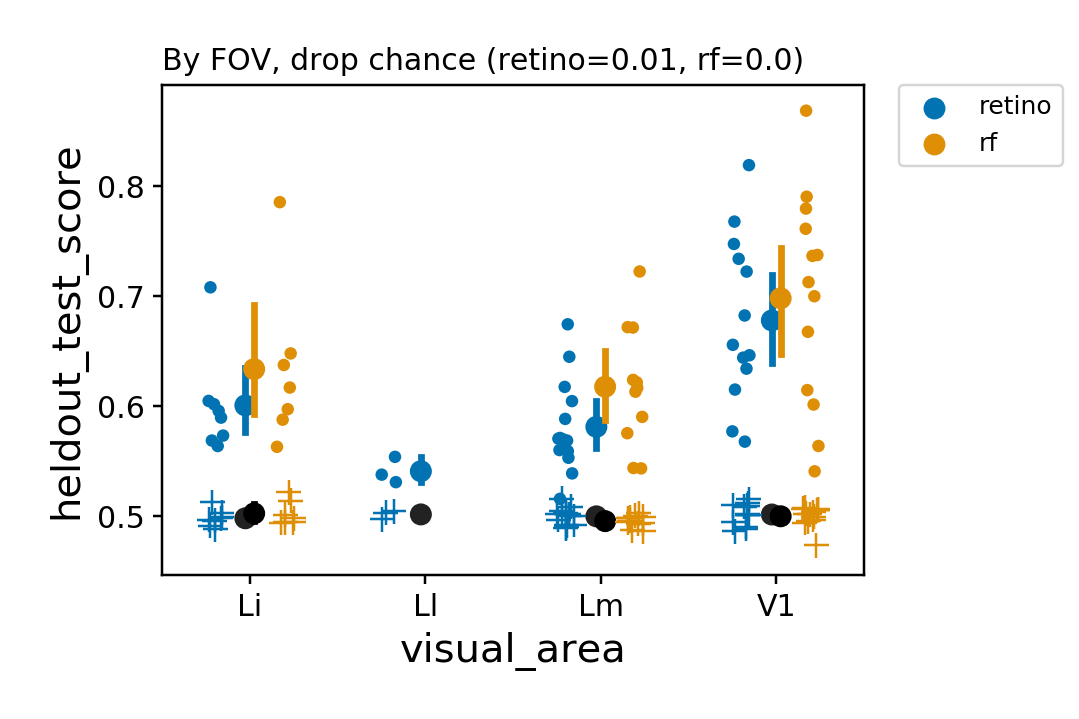

In [111]:
# for visual_area, g in meand.groupby(['visual_area']):
#     ai=visual_areas.index(visual_area)
#ax=axn[i]

d_ = passd.copy()

fig, ax = pl.subplots(figsize=(6,4))
metric = 'heldout_test_score'

sns.stripplot(x='visual_area', y=metric, data=d_[d_['condition']=='data'], ax=ax, 
              hue='filter', dodge=True)
sns.pointplot(x='visual_area', y=metric, data=d_[d_['condition']=='data'], ax=ax, 
              hue='filter', dodge=True, join=False)

sns.stripplot(x='visual_area', y=metric, data=d_[d_['condition']=='shuffled'], ax=ax, 
              hue='filter', dodge=True, edgecolor='k', facecolor='k', marker='+', s=10, linewidth=1)
sns.pointplot(x='visual_area', y=metric, data=d_[d_['condition']=='shuffled'], ax=ax, 
              hue='filter', dodge=True, join=False, color='k', marker='.')

              
# Get the handles and labels.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
l = pl.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
              
#ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.8, left=0.15, bottom=0.2)

ax.set_title("By FOV, drop chance (retino=0.01, rf=0.0)", loc='left')

pl.savefig(os.path.join(curr_dst_dir, 'retino_vs_rf_filters_all_pass.svg'))

#### Compare paired

In [96]:
bothd = pd.concat([g for (v, dk), g in passd.groupby(['visual_area', 'datakey']) \
             if 'retino' in g['filter'].values and 'rf' in g['filter'].values])
bothd.shape, meand.shape

((108, 16), (146, 16))

<IPython.core.display.Javascript object>


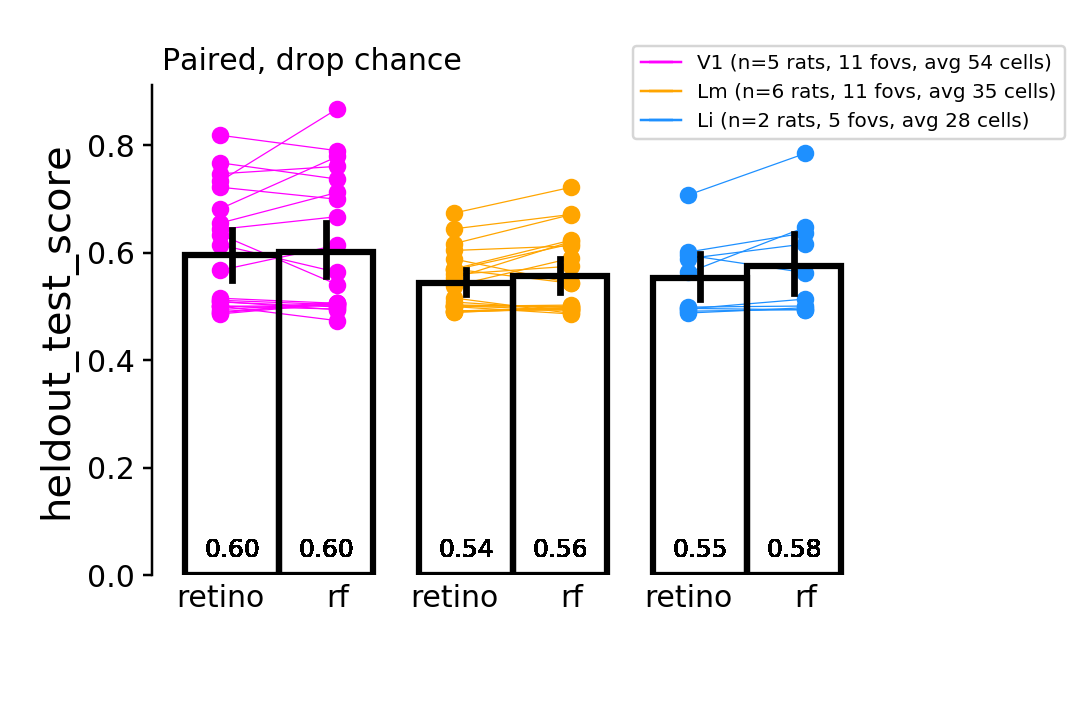

V1: (t-stat:-0.61, p=0.55)
Lm: (t-stat:-1.80, p=0.09)
Li: (t-stat:-1.95, p=0.08)


In [113]:
fig, ax = pl.subplots(figsize=(6,4))
ax = aggr.plot_pairwise_by_axis(bothd, curr_metric=metric, c1='retino', c2='rf', compare_var='filter',
                                        ax=ax, area_colors=area_colors)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(bothd, area_colors=area_colors)
ax.legend(handles=legend_elements, bbox_to_anchor=(1.3,1.1), fontsize=8)

pl.subplots_adjust(left=0.15, right=0.8, bottom=0.2)

ax.set_title("Paired, drop chance", loc='left')

pl.savefig(os.path.join(curr_dst_dir, 'retino_vs_rf_filters_all_pass_paired.svg'))

#### Compare N cells and accuracy for both filter typesm

<IPython.core.display.Javascript object>


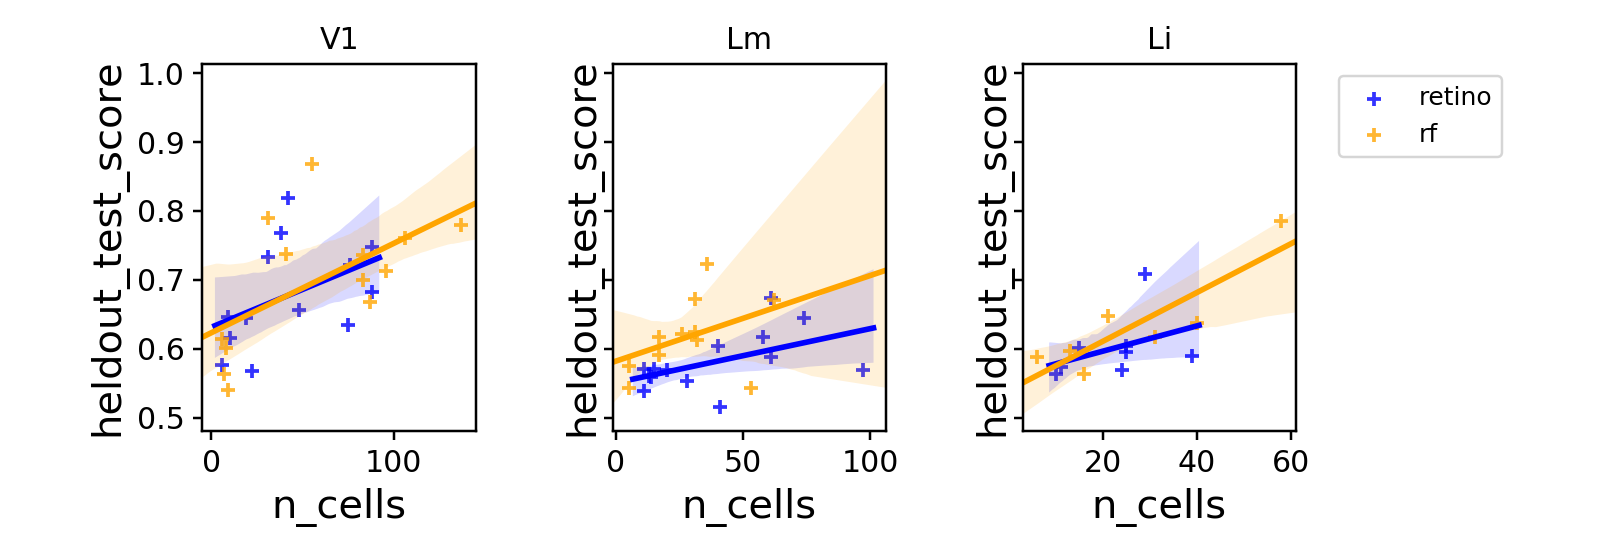

In [154]:
color_by_filter=True

subd = passd[passd['condition']=='data'][['visual_area', 'datakey', 'filter', 'n_cells', metric]].copy()

fig, axn = pl.subplots(1,3, figsize=(9,3), sharex=not color_by_filter, sharey=True)
for v, g in subd.groupby(['visual_area']):
    if v=='Ll':
        continue
    ai=visual_areas.index(v)
    ax=axn[ai]
    if color_by_filter:
        sns.regplot(x='n_cells', y=metric, ax=ax, data=g[g['filter']=='retino'], 
                    color='b', label='retino', marker='+')
        sns.regplot(x='n_cells', y=metric, ax=ax, data=g[g['filter']=='rf'],
                    color='orange', label='rf', marker='+')

    else:
        sns.regplot(x='n_cells', y=metric, ax=ax, data=g, color='k')
        ax.scatter(g[g['filter']=='retino']['n_cells'], g[g['filter']=='retino'][metric], color='b', label='retino')
        ax.scatter(g[g['filter']=='rf']['n_cells'], g[g['filter']=='rf'][metric], color='orange', label='rf')

#     ax.scatter(g[g['filter']=='retino']['n_cells'], g[g['filter']=='retino'][metric], color='b', label='retino')
#     ax.scatter(g[g['filter']=='rf']['n_cells'], g[g['filter']=='rf'][metric], color='orange', label='rf')
    
    
    ax.set_title(v)

axn[-1].legend(bbox_to_anchor=(1.8, 1))

pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)

pl.savefig(os.path.join(curr_dst_dir, 'ncells_by_%s.svg' % metric))

# Filter cells

In [145]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [146]:
has_retino=True
retino_mag_thr = 0.01
retino_pass_criterion='all'

if has_retino:
    print("~~~~~~~~~~~~~~~~Loading Retinotopy Bar ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    edata = sdata[sdata['experiment'].isin(['retino'])]
    assigned_rois, missing_ = seg.get_cells_by_area(edata, return_missing=True)
    retino_cells = aggr.aggregate_responsive_retino(assigned_rois, traceid=traceid,
                                    mag_thr=retino_mag_thr, pass_criterion=retino_pass_criterion, 
                                    verbose=False, create_new=True)
    retino_cells = retino_cells[retino_cells['visual_area'].isin(visual_areas)]
print("Missing %i retino analyses" % len(missing_))
for r in missing_:
    print(r)

~~~~~~~~~~~~~~~~Loading Retinotopy Bar ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Segmentation: missing 3 dsets
No data: /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2/retino_analysis/analysisids_retino_run2.json
NO retino for traceid traces001
(check dir: /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2)
No data: /n/coxfs01/2p-data/JC070/20190315/FOV3_zoom2p0x/retino_run1/retino_analysis/analysisids_retino_run1.json
NO retino for traceid traces001
(check dir: /n/coxfs01/2p-data/JC070/20190315/FOV3_zoom2p0x/retino_run1)
---> Saved: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_retino_magratio_all-thr-0.01.pkl
Missing 3 retino analyses
('20190314_JC070_fov1', 'retino_run2')
('20190327_JC073_fov1', 'retino_run1')
('20190327_JC073_fov1', 'retino_run2')


In [154]:
c1 = retino_cells[(retino_cells['visual_area']==visual_area) 
             & (retino_cells['datakey']==datakey)]['cell'].values
c2 = [c for c in MEANS[datakey].columns.tolist() if c!='config']

In [159]:
# len(np.intersect1d(c1, c2))
globalcells, cell_counts = aggr.global_cells(retino_cells,
                                            remove_too_few=False,
                                            min_ncells=5, return_counts=True)
cell_counts

Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']


{u'Li': 432, u'Ll': 113, u'Lm': 959, u'V1': 868}

In [147]:
retino_cells[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


datakey  cell
visual_area               
Li               432   432
Ll               113   113
Lm               959   959
V1               868   868

In [148]:
# RF dataframes
NEURALDATA = aggr.get_neuraldata(retino_cells, MEANS, stack=True)

In [149]:
retino_cells[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


datakey  cell
visual_area               
Li               432   432
Ll               113   113
Lm               959   959
V1               868   868

In [151]:

NEURALDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


datakey  cell
visual_area               
V1                76    76

In [ ]:
### Load RF fits -------------------------------------
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05
# -----------------------------------------------------

stack_neuraldf=True
#### Load RFs
NEURALDATA=None; RFDATA=None;
if has_rfs:
    print("~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)
    reliable_str = 'reliable' if reliable_only else ''

    # Get position info for RFs
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=None,
                                    reliable_only=True, traceid=traceid)
    # RF dataframes
    NEURALDATA, RFDATA, assigned_cells = aggr.get_neuraldata_and_rfdata(assigned_cells, rfdf, MEANS,
                                            stack=True)
    # Get subset of cells with RFs
#     assigned_cells = pd.concat([cells[(cells['visual_area']==v) 
#                               & (cells['datakey']==dk) 
#                               & (cells['cell'].isin(g['cell'].unique()))] \
#                         for (v, dk), g in RFDATA.groupby(['visual_area', 'datakey'])])

else:
    print("~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~")
    # EXP dataframes
    NEURALDATA = aggr.get_neuraldata(assigned_cells, MEANS, stack=stack_neuraldf)

In [ ]:
# NEURALDATA


# decode_from_fov(curr_datakey, curr_visual_area, neuraldf, sdf, C_value=C_value,
#                             n_iterations=n_iterations, n_processes=n_processes,
#                             results_id=results_id,
#                             class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
#                             rootdir=rootdir, create_new=create_new, verbose=verbose)


# Get aggregate data

In [210]:
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False)

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[V1] Animalid does not exist: JC078 


In [211]:
all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))


Dropping 11 dkeys (31 of 42 dkeys unique)


In [212]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.pyc'>

In [419]:
C_value=None
trial_epoch='plushalf'
analysis_type='by_fov'

overlap_thr=0
has_retino=False
# -------------------------------------------------------------------------------------

C_str = 'tuneC' if C_value is None else 'C%.2f' % float(C_value)
if has_retino:
    overlap_str = 'retino'
else:
    overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % float(overlap_thr)
data_id = '%s__%s-%s_%s_%s_%s' \
                % (analysis_type, response_type, responsive_test, overlap_str,
                                trial_epoch, C_str)
print(data_id)

df = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, 
                    responsive_test=responsive_test, responsive_thr=responsive_thr,
                    response_type=response_type, traceid=traceid, trial_epoch=trial_epoch,
                    C_value=C_value, overlap_thr=overlap_thr, has_retino=has_retino, verbose=True)

df['animalid'] = [d.split('_')[1] for d in df['datakey']]
df['session'] = [d.split('_')[0] for d in df['datakey']]
df['fovnum'] = [int(d.split('_')[2][3:]) for d in df['datakey']]


by_fov__dff-nstds_overlap0.0_plushalf_tuneC
AGGREGATE: by_fov___dff-nstds_overlap0.0__plushalf__tuneC
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
JC091|20190602|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190606|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190607|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190609|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190612|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC091|20190614|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190617|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC113|20191018|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC120|20191111|FOV1_zoom2p0x -- by_fov_Li__dff-nstds_overlap0.0__plushalf__tuneC
JC099|20190612|FOV1_zoom2p0x -- by_fov_Ll__dff-nstds_overlap0.0__plushalf__tuneC
JC078|20190430|FOV1_zoom2p0x

In [420]:
dropdf = df[df['datakey'].isin(unique_dkeys)].copy()

In [421]:
df.shape, dropdf.shape

((6200, 18), (4600, 18))

In [422]:
df.groupby(['visual_area', 'condition']).mean()

C  fit_time  heldout_MI  heldout_aMI  \
visual_area condition                                                 
Li          data       17.868790  0.105205    0.054828     0.068469   
            shuffled   32.853546  0.438101    0.008349     0.000450   
Lm          data       16.371885  0.166225    0.043053     0.049976   
            shuffled   31.737929  0.457101    0.008739    -0.000333   
V1          data       10.953148  0.046824    0.113258     0.153031   
            shuffled   28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
visual_area condition                                                   
Li          data             0.079101            0.633587    0.000670   
            shuffled         0.012045            0.502461    0.000816   
Lm          data             0.062113            0.617536    0.000596   
            shuffled         0.012608            0.495404    0.000677   
V1          data             0.163397            0.697965    0.000823   
            shuffled         0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
visual_area condition                                                   
Li          data         0.634041     0.709515  26.428571  340.000000   
            shuffled     0.510796     0.618824  26.428571  340.000000   
Lm          data         0.616604     0.711315  28.636364  292.727273   
            shuffled     0.505423     0.631553  28.636364  292.727273   
V1          data         0.696744     0.789706  57.615385  305.384615   
            shuffled     0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
visual_area condition                     
Li          data            49.5     1.0  
            shuffled        49.5     1.0  
Lm          data            49.5     1.0  
            shuffled        49.5     1.0  
V1          data            49.5     1.0  
            shuffled        49.5     1.0

In [423]:
df[['visual_area', 'datakey', 'n_cells']].drop_duplicates().groupby(['visual_area']).sum()

n_cells
visual_area         
Li               185
Lm               315
V1               749

In [424]:
subdir = data_id.split('__')[-1]

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type, subdir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC


In [425]:
if 'pupil' in analysis_type:
    diffs=[]
    scores=[]
    for (visual_area, datakey), g in df.groupby(['visual_area', 'datakey']):
        n_low = int(g[g['arousal']=='low']['n_trials'].values)
        n_high = int(g[g['arousal']=='high']['n_trials'].values)
        if n_low!=n_high:
            print('[%s] %s, low=%i, high=%i' % (visual_area, datakey, n_low, n_high))
            diffs.append(n_high - n_low)
            score_high = float(g[g['arousal']=='high'][metric].values)
            score_low = float(g[g['arousal']=='low'][metric].values)
            scores.append(score_high-score_low)     
            
    diffs=np.array(diffs)
    scores=np.array(scores)
    diff_ixs = np.argsort(diffs)

    f, ax = pl.subplots(figsize=(4,4))
    ax.scatter(diffs, scores)
    ax.set_xlim([-16, 16])
    f.text(0, 0.9, "Difference in trial # vs. score difference (low v high)")
    pear_r, pear_p = spstats.pearsonr(diffs, scores)
    ax.set_title('pearson r=%.2f (p=%.2f)' %(pear_r, pear_p), loc='left', fontsize=12)
    pl.subplots_adjust(top=0.7, bottom=0.2, left=0.2)

    ax.set_xlabel('n trials diff')
    ax.set_ylabel('score diff')
    
    figname = 'ntrials_v_score_diffs__%s' % C_str
    putils.label_figure(f, data_id)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    

## N cells v accuracy

<IPython.core.display.Javascript object>


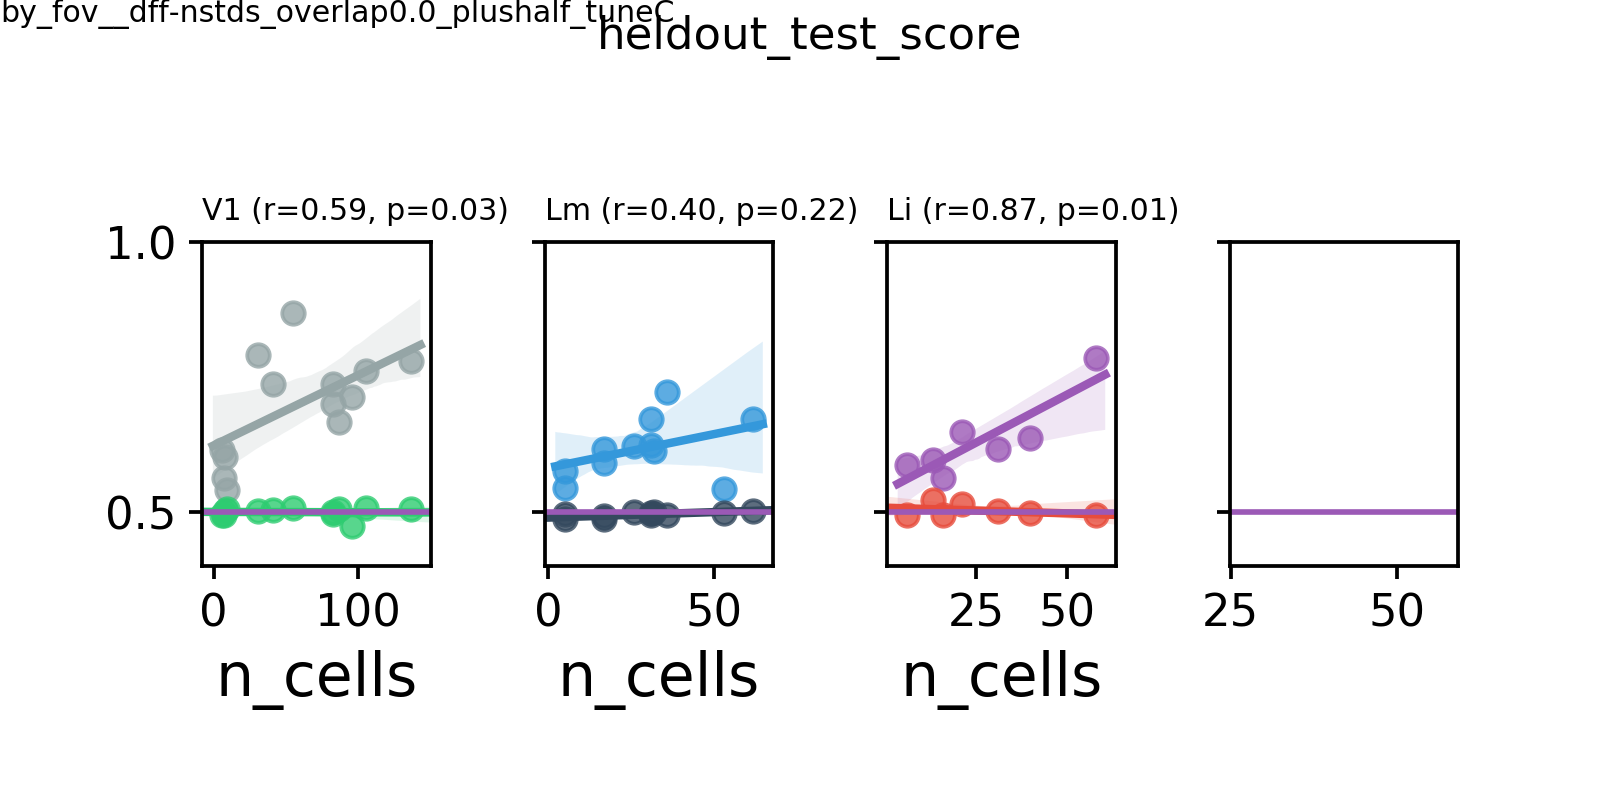

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'corr_ncells_heldout_test_score_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [426]:
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
metric='heldout_test_score'

if 'pupil' in analysis_type:
    xdf = df[df['arousal']=='all'].copy()
else:
    xdf = df.copy() #[df['condition']=='data'].copy()
    
f, axn = pl.subplots(1, len(visual_areas), dpi=dpi, figsize=(6,3), sharex=False, sharey=True)
f.patch.set_alpha(1)

mean_scores = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
for ai, (visual_area, vdf) in enumerate(mean_scores[mean_scores['condition']=='data'].groupby(['visual_area'])):
    ax=axn[2-ai]
    sns.regplot(x='n_cells', y=metric, data=vdf, ax=ax)
    pear_r, pear_p = spstats.pearsonr(vdf['n_cells'].values, vdf[metric].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, pear_r, pear_p), loc='left', fontsize=8)
    ax.set_ylabel('')


mean_scores = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
for ai, (visual_area, vdf) in enumerate(mean_scores[mean_scores['condition']=='shuffled'].groupby(['visual_area'])):
    ax=axn[2-ai]
    sns.regplot(x='n_cells', y=metric, data=vdf, ax=ax)
    pear_r, pear_p = spstats.pearsonr(vdf['n_cells'].values, vdf[metric].values)
    #ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, pear_r, pear_p), loc='left', fontsize=8)
    ax.set_ylabel('')

for ax in axn.flat:
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5)
    
f.suptitle(metric)
putils.label_figure(f, data_id)
pl.subplots_adjust(wspace=0.5, top=0.7, bottom=0.3)

figname = 'corr_ncells_%s_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

### Bin dsets by N_CELLS

In [427]:
n_bins=3
print(pd.cut(df['n_cells'], n_bins, labels=np.arange(0, n_bins)).value_counts())
print(pd.cut(df['n_cells'], n_bins).value_counts())


# tmp_keys = ['20190507_JC083_fov1', '20190511_JC083_fov1']

df['ncells_bin'] = pd.qcut(df['n_cells'], n_bins) #, labels=np.arange(0, n_bins))

print(pd.qcut(df['n_cells'], n_bins).value_counts())


0    4200
1    1400
2     600
Name: n_cells, dtype: int64
(4.868, 49.0]    4200
(49.0, 93.0]     1400
(93.0, 137.0]     600
Name: n_cells, dtype: int64
(4.999, 17.0]    2200
(41.0, 137.0]    2000
(17.0, 41.0]     2000
Name: n_cells, dtype: int64


In [428]:
# df.groupby(['condition', 'visual_area', 'ncells_bin']).mean()

<IPython.core.display.Javascript object>


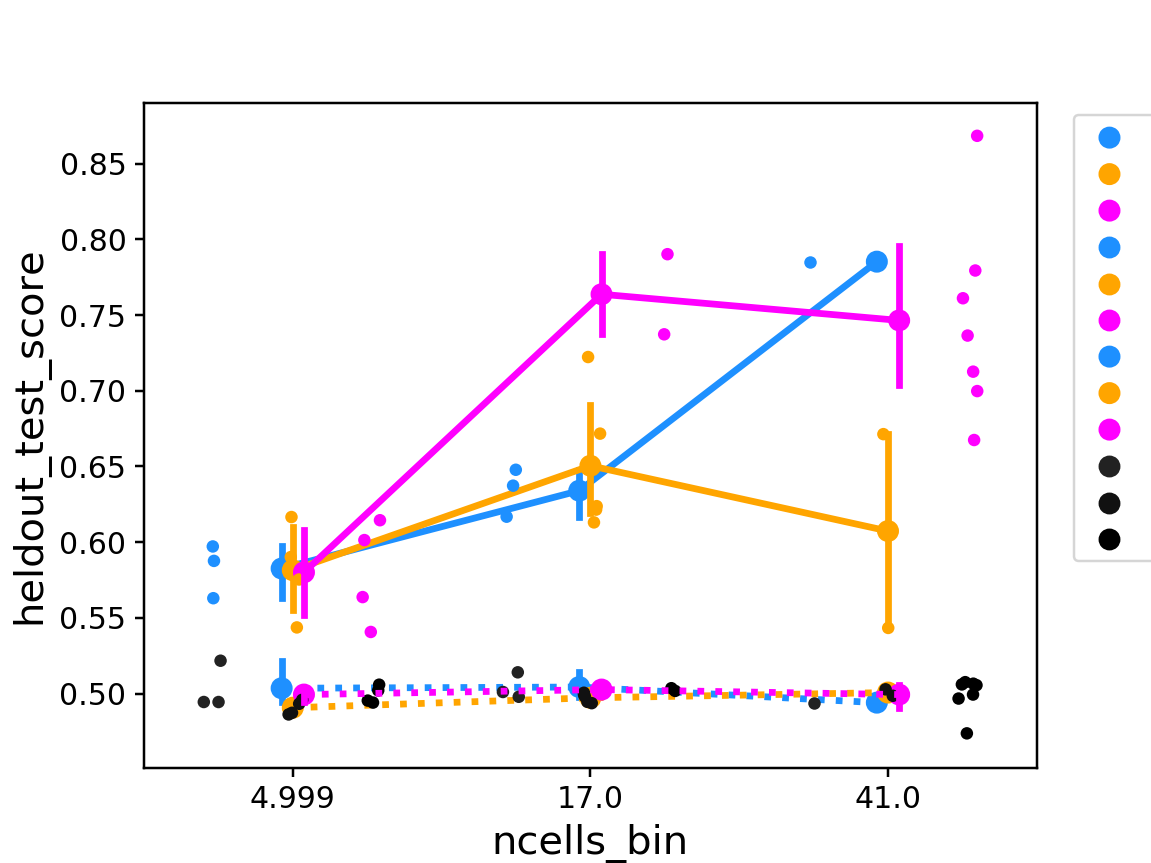

In [467]:
# df.groupby(['condition', 'visual_area', 'ncells_bin']).mean()
line_styles = {'data': '-', 'shuffled': ':'}
fig, ax = pl.subplots()
for cond, cond_df in df.groupby(['condition']):
    
    mean_ = cond_df.groupby(['visual_area', 'datakey', 'ncells_bin']).mean().reset_index()
    
    #for visual_area, vdf in cond_df.groupby(['visual_area']):

    #mean_ = vdf.groupby(['ncells_bin']).mean().reset_index()

    #tmpd = vdf.groupby(['datakey', 'ncells_bin']).mean().reset_index()
    #bin_names = mean_['ncells_bin'].values
    bin_names = [i.left for i in mean_.groupby(['ncells_bin']).mean().reset_index()['ncells_bin']]

    sns.pointplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  markers='o', scale=1, palette=area_colors, linestyles=line_styles[cond]) #, capsize=1, )

    if cond=='shuffled':
        sns.stripplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  marker='o', color='k') #, linestyles=line_styles[cond]) #, capsize=1, )

    else:   
        sns.stripplot(x='ncells_bin', y=metric, data=mean_, ax=ax, hue='visual_area', dodge=True,
                  marker='o', palette=area_colors)

    #ax.plot(np.arange(0, len(bin_names)), mean_[metric].values, color=area_colors[visual_area], linestyle=line_styles[cond])
    ax.set_xticks(np.arange(0, len(bin_names)))
    ax.set_xticklabels(bin_names)
ax.legend(bbox_to_anchor=(1.2, 1))

# Average classifier accuracy

In [499]:

drop_repeats=False
dset_str = 'drop_repeats' if (drop_repeats and filter_by is not None) else 'all_datasets'
print(dset_str)
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
DF = dropdf.copy() if drop_repeats else df.copy()
print(DF.shape)
min_ncells=0

bad_training = [] #df[df['test_score']<0.25]['datakey'].unique()
few_cells = DF[DF['n_cells']<min_ncells]['datakey'].unique()
excluded = np.union1d(bad_training, few_cells)

plotdf = DF[~DF['datakey'].isin(excluded)]
print("Excluded:", excluded)

all_datasets
(6200, 19)
('Excluded:', array([], dtype=object))


In [500]:
meandf = plotdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

passdf = pd.concat([g for (v, k), g in meandf.groupby(['visual_area', 'datakey']) \
    if float(g[g['condition']=='shuffled'][metric]) < float(g[g['condition']=='data'][metric])])
passdf.groupby(['condition', 'visual_area']).mean()
# for (v, k), g in meandf.groupby(['visual_area', 'datakey']):
#     g

C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area                                                 
data      Li           17.868790  0.105205    0.054828     0.068469   
          Lm           16.371885  0.166225    0.043053     0.049976   
          V1           10.953148  0.046824    0.113258     0.153031   
shuffled  Li           32.853546  0.438101    0.008349     0.000450   
          Lm           31.737929  0.457101    0.008739    -0.000333   
          V1           28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
condition visual_area                                                   
data      Li                 0.079101            0.633587    0.000670   
          Lm                 0.062113            0.617536    0.000596   
          V1                 0.163397            0.697965    0.000823   
shuffled  Li                 0.012045            0.502461    0.000816   
          Lm                 0.012608            0.495404    0.000677   
          V1                 0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
condition visual_area                                                   
data      Li             0.634041     0.709515  26.428571  340.000000   
          Lm             0.616604     0.711315  28.636364  292.727273   
          V1             0.696744     0.789706  57.615385  305.384615   
shuffled  Li             0.510796     0.618824  26.428571  340.000000   
          Lm             0.505423     0.631553  28.636364  292.727273   
          V1             0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
condition visual_area                     
data      Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0  
shuffled  Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0

In [501]:
meandf.groupby(['condition', 'visual_area']).mean()


C  fit_time  heldout_MI  heldout_aMI  \
condition visual_area                                                 
data      Li           17.868790  0.105205    0.054828     0.068469   
          Lm           16.371885  0.166225    0.043053     0.049976   
          V1           10.953148  0.046824    0.113258     0.153031   
shuffled  Li           32.853546  0.438101    0.008349     0.000450   
          Lm           31.737929  0.457101    0.008739    -0.000333   
          V1           28.507254  0.795552    0.008271    -0.000372   

                       heldout_log2MI  heldout_test_score  score_time  \
condition visual_area                                                   
data      Li                 0.079101            0.633587    0.000670   
          Lm                 0.062113            0.617536    0.000596   
          V1                 0.163397            0.697965    0.000823   
shuffled  Li                 0.012045            0.502461    0.000816   
          Lm                 0.012608            0.495404    0.000677   
          V1                 0.011933            0.499814    0.000964   

                       test_score  train_score    n_cells    n_trials  \
condition visual_area                                                   
data      Li             0.634041     0.709515  26.428571  340.000000   
          Lm             0.616604     0.711315  28.636364  292.727273   
          V1             0.696744     0.789706  57.615385  305.384615   
shuffled  Li             0.510796     0.618824  26.428571  340.000000   
          Lm             0.505423     0.631553  28.636364  292.727273   
          V1             0.509244     0.686531  57.615385  305.384615   

                       iteration  fovnum  
condition visual_area                     
data      Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0  
shuffled  Li                49.5     1.0  
          Lm                49.5     1.0  
          V1                49.5     1.0

29 unique datakeys


<IPython.core.display.Javascript object>


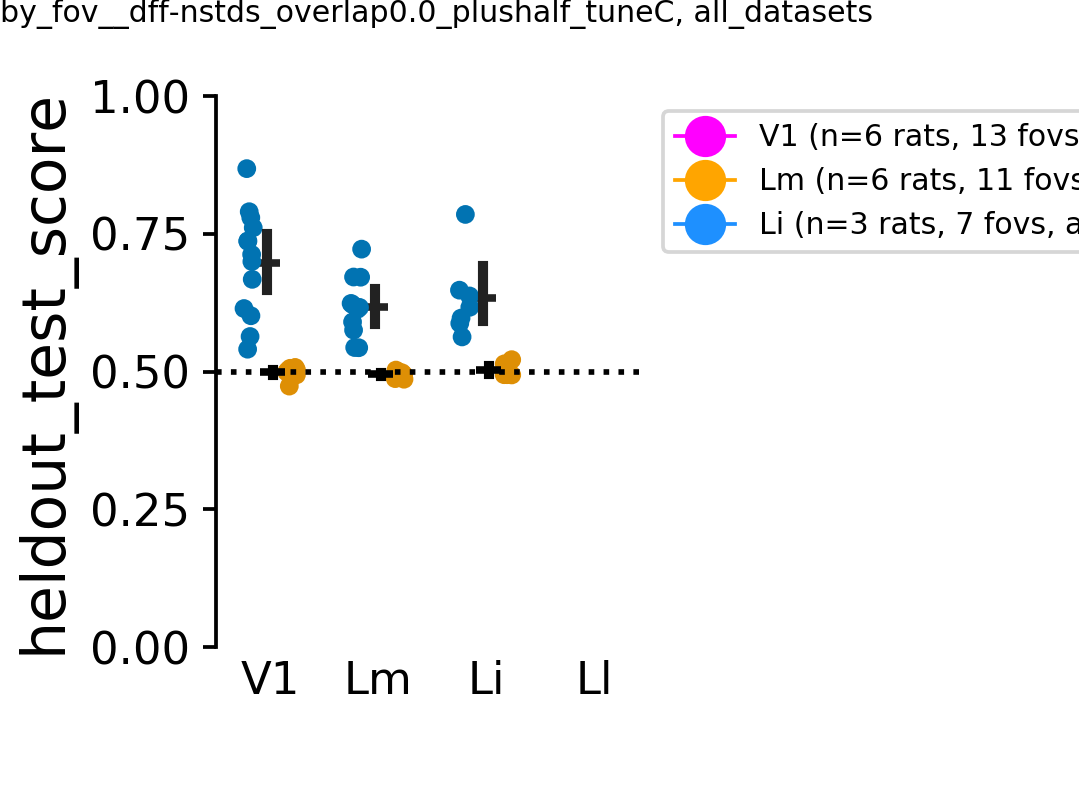

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'heldout_test_score_shuffled-v-true_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [502]:
metric = 'heldout_test_score'
#metric = 'test_score'

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy() #plotdf.copy()
    
df_ = passdf.copy() #xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
print("%i unique datakeys" % len(df_['datakey'].unique()))

f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
f.patch.set_alpha(1)

# PLOT.
sns.pointplot(x='visual_area', y=metric, data=df_, ax=ax, 
              order=visual_areas, hue='condition', 
             color='k', markers='_', scale=1, join=False, dodge=True) #facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=df_, ax=ax, 
              hue='condition',palette='colorblind', 
              order=visual_areas, zorder=1, s=5, dodge=True) #. palette=area_colors, 

leg = aggr.get_counts_for_legend(df_, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1), fontsize=8)

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True)
 
putils.label_figure(f, '%s, %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.6)



#### Save
figname = '%s_shuffled-v-true_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [440]:
dset_str

'all_datasets'

# Compare accuracy for data across areas

In [435]:
area_colors.update({"Li": 'dodgerblue', 'Ll': 'k'})

In [497]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

<IPython.core.display.Javascript object>


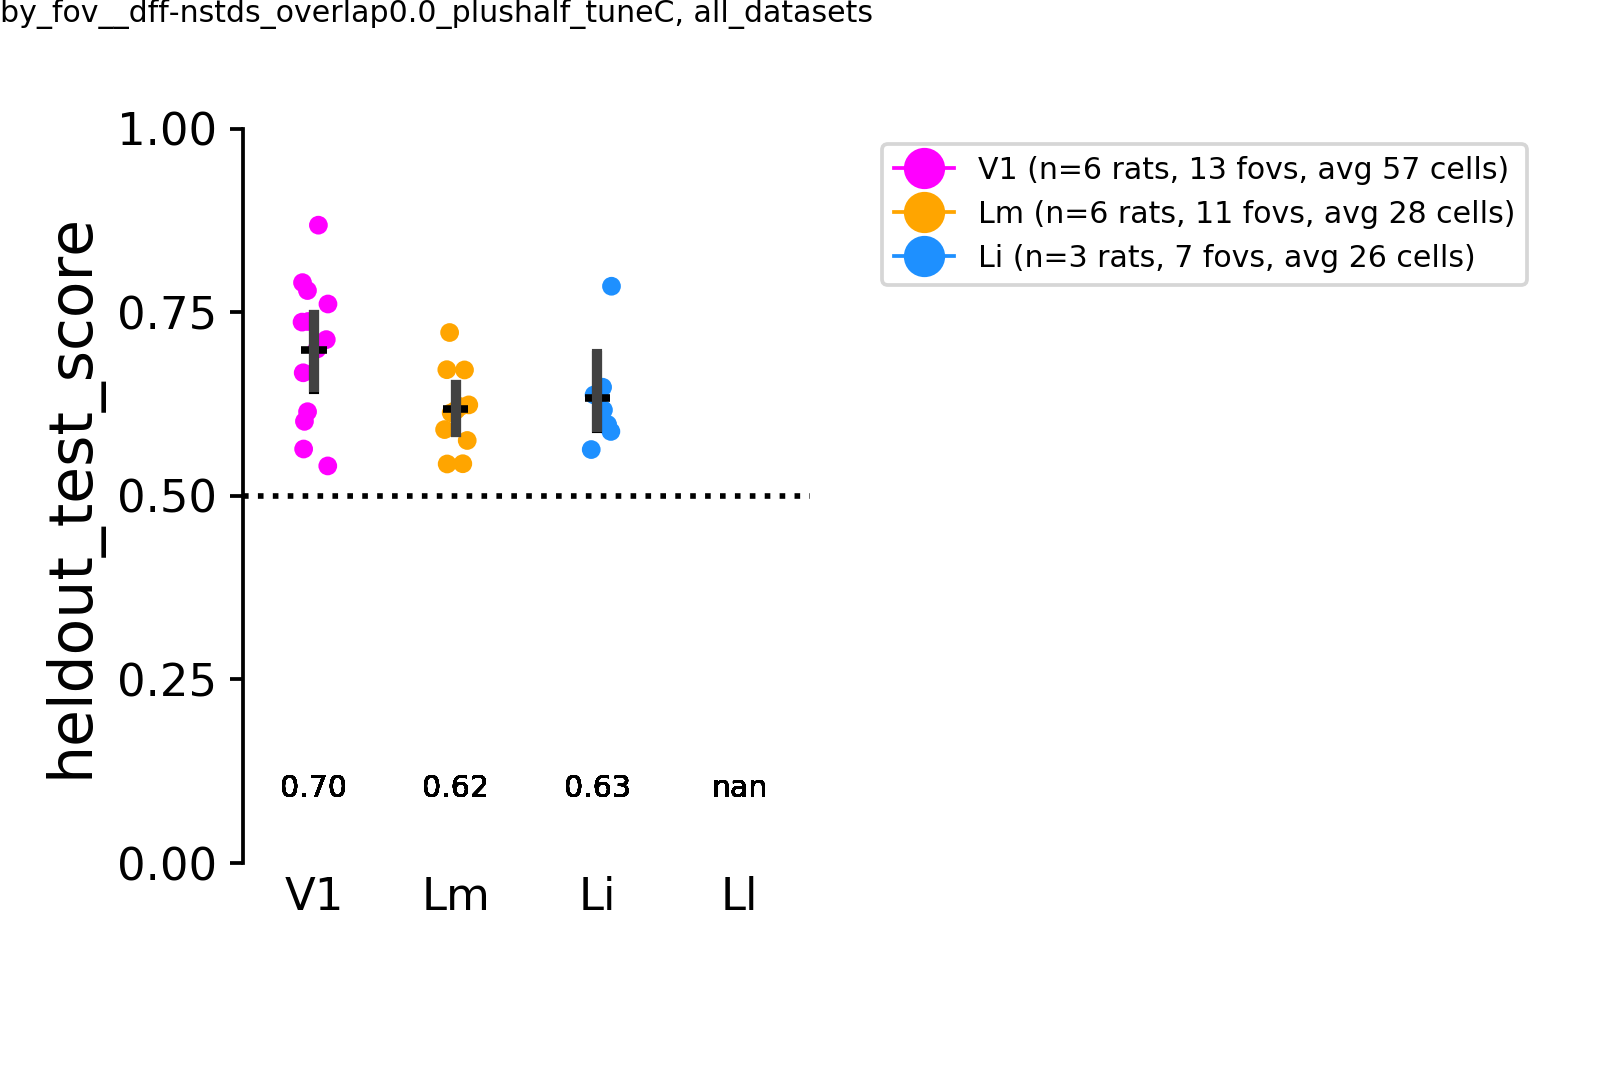

visual_area
Li    26.428571
Lm    28.636364
V1    57.615385
Name: n_cells, dtype: float64
********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.084 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.133 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.393 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_overlap0.0_plushalf_tuneC', 'overall_heldout_test_score_by_fov__dff-nstds_overlap0.0_plushalf_tuneC__all_datasets')


In [503]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
#metric = 'test_score'
multi_comp_test='fdr_bh'


f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

#df_ = passdf.copy() #xdf[(xdf['condition']=='data')].copy()
df_ = passdf[passdf['condition']=='data'].copy()
print(df_.groupby(['visual_area']).mean()['n_cells'])

sns.stripplot(x='visual_area', y=metric, data=df_, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=5)
sns.pointplot(x='visual_area', y=metric, data=df_, ax=ax, order=visual_areas,
              markers='_', color='k', join=False, zorder=0)
sns.barplot(x='visual_area', y=metric, data=df_, ax=ax,
             color='none', facecolor='none', edgecolor='none', order=visual_areas)

df_.apply(aggr.annotateBars, ax=ax, axis=1, 
             fontsize=8, fontcolor='k', fmt='%.2f', xytext=(0, 20))
    
#### Stats
statsresults, ax = aggr.plot_mannwhitney(df_, metric=metric, 
                                         multi_comp_test=multi_comp_test, ax=ax)

#### Legend
leg = aggr.get_counts_for_legend(df_, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.1, 1), fontsize=8)

#### Formatting
if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
    
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True)
 
putils.label_figure(f, '%s, %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.5)

#### Save

#### Save
figname = 'overall_%s_%s__%s' % (metric, data_id, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [480]:
df_.groupby(['visual_area']).mean()['n_cells']

visual_area
Li    22.500000
Lm    27.222222
V1    67.100000
Name: n_cells, dtype: float64

In [452]:
df_

visual_area              datakey condition         C  fit_time  heldout_MI  \
0           Li  20190602_JC091_fov1      data   0.03070  0.003669    0.185412   
2           Li  20190606_JC091_fov1      data  35.32033  0.135654    0.014885   
4           Li  20190607_JC091_fov1      data  23.68873  0.393171    0.036250   
6           Li  20190609_JC099_fov1      data  31.23730  0.139067    0.052685   
8           Li  20190612_JC099_fov1      data  10.31230  0.022308    0.029852   
10          Li  20190614_JC091_fov1      data   0.52687  0.011321    0.045978   
12          Li  20191018_JC113_fov1      data  23.96530  0.031244    0.018737   
14          Lm  20190430_JC078_fov1      data   3.41776  0.028361    0.040599   
16          Lm  20190504_JC078_fov1      data   2.54188  0.002135    0.018603   
18          Lm  20190506_JC080_fov1      data  13.62790  0.135979    0.067996   
20          Lm  20190508_JC083_fov1      data  11.11780  0.133619    0.069841   
22          Lm  20190512_JC083_fov1      data  31.60261  0.354386    0.032465   
24          Lm  20190513_JC078_fov1      data  16.74775  0.048679    0.024031   
26          Lm  20190517_JC083_fov1      data  23.52133  0.057517    0.034726   
28          Lm  20190525_JC084_fov1      data  16.51060  0.127742    0.111398   
30          Lm  20190603_JC080_fov1      data  45.26965  0.931134    0.012468   
32          Lm  20190618_JC097_fov1      data   0.12088  0.003062    0.049750   
34          Lm  20190627_JC091_fov1      data  15.61258  0.005861    0.011709   
36          V1  20190420_JC076_fov1      data   0.42625  0.001820    0.035083   
38          V1  20190501_JC076_fov1      data   5.89942  0.007250    0.012788   
40          V1  20190507_JC083_fov1      data   0.38080  0.002978    0.318090   
42          V1  20190508_JC083_fov1      data   0.54694  0.001627    0.052993   
44          V1  20190510_JC083_fov1      data  35.54281  0.262987    0.189933   
46          V1  20190511_JC083_fov1      data  34.75675  0.260073    0.129398   
48          V1  20190512_JC083_fov1      data  64.21546  0.039709    0.015744   
50          V1  20190522_JC084_fov1      data   0.06490  0.005382    0.156123   
52          V1  20190613_JC097_fov1      data   0.03331  0.005305    0.101449   
54          V1  20190616_JC097_fov1      data   0.09640  0.007753    0.176905   
56          V1  20190617_JC097_fov1      data   0.02071  0.003027    0.093852   
58          V1  20190622_JC085_fov1      data   0.38638  0.005808    0.065241   
60          V1  20191006_JC110_fov1      data   0.02080  0.004998    0.124752   

    heldout_aMI  heldout_log2MI  heldout_test_score  score_time  test_score  \
0      0.258011        0.267492            0.785345    0.000509    0.776971   
2      0.010014        0.021475            0.562969    0.000686    0.570954   
4      0.040371        0.052298            0.616833    0.000533    0.616667   
6      0.064458        0.076008            0.647833    0.000619    0.647542   
8      0.031020        0.043067            0.597167    0.000417    0.591792   
10     0.054657        0.066333            0.637333    0.000695    0.639708   
12     0.020750        0.027031            0.587632    0.001232    0.594653   
14     0.046368        0.058573            0.623793    0.000573    0.615886   
16     0.014448        0.026839            0.575333    0.000374    0.575417   
18     0.086423        0.098098            0.671724    0.000502    0.658719   
20     0.089106        0.100759            0.671379    0.000692    0.670770   
22     0.035321        0.046837            0.613065    0.000744    0.613810   
24     0.022152        0.034670            0.590172    0.000535    0.593143   
26     0.035739        0.050099            0.616600    0.000483    0.619150   
28     0.150224        0.160714            0.722333    0.000672    0.718208   
30     0.005414        0.017988            0.543333    0.000775    0.547000   
32     0.060032        0.071774            0.621500    0.000808    

# Split by arousal

<IPython.core.display.Javascript object>


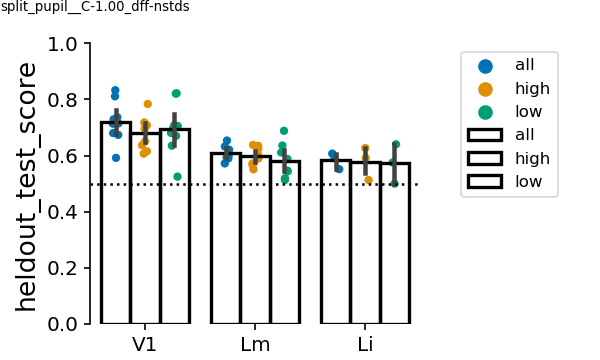

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/split_pupil', 'split_low-v-high_heldout_test_score__C-1.00')


In [391]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [24]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10),
                          area_colors=None, legend=True):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = aggr.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)
    
    # Set x labels
    aggr.set_split_xlabels(ax, a_label=c1, b_label=c2)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

    return fig


In [25]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

<IPython.core.display.Javascript object>


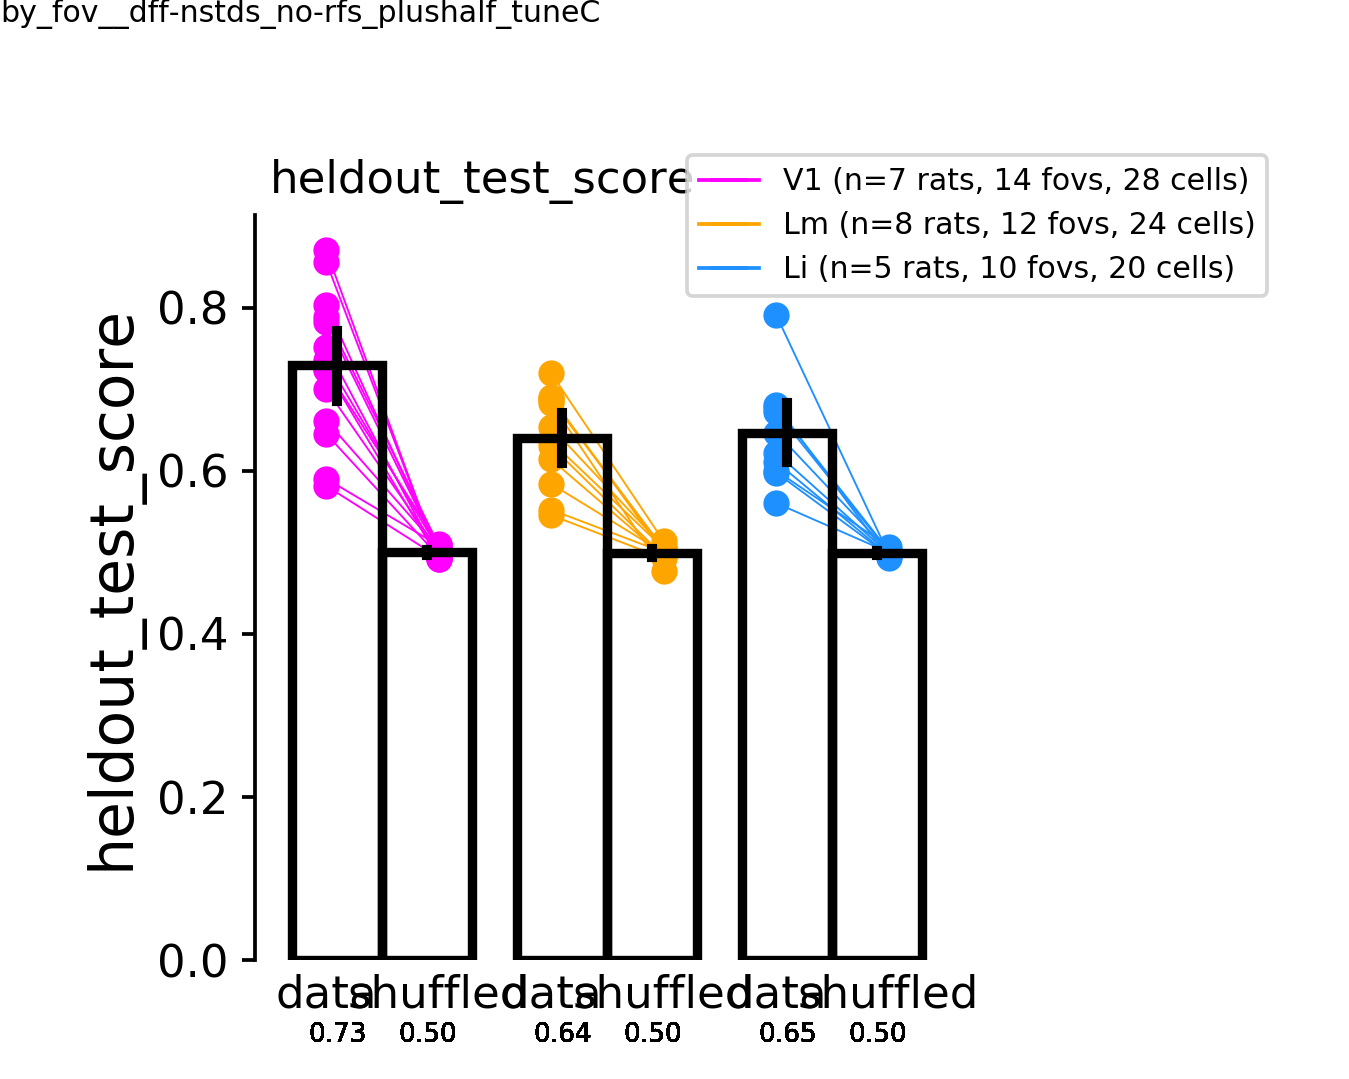

V1: (t-stat:9.52, p=0.00)
Lm: (t-stat:8.79, p=0.00)
Li: (t-stat:7.09, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/dff-nstds_no-rfs_plushalf_tuneC', 'paired_low-v-high_heldout_test_score__tuneC')


In [26]:
metric = 'heldout_test_score'
#metric = 'abs_coef'

if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'

for metric in ['heldout_test_score']: #, 'heldout_log2MI', 'n_trials']:
    fig = plot_pairwise_by_axis(currdf, curr_metric=metric, 
                                c1=c1, c2=c2, compare_var=compare_var,
                               area_colors=area_colors, fontsize=7, 
                                fontcolor='k', fmt='%.2f', xytext=(0, -20))
    
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [164]:
currdf.head()

visual_area              datakey condition        C  fit_time  heldout_MI  \
0          Li  20190315_JC070_fov1      data  0.59230  0.007353    0.056369   
1          Li  20190315_JC070_fov1  shuffled  0.59230  0.019664    0.013749   
2          Li  20190316_JC070_fov1      data  2.60830  0.057331    0.026365   
3          Li  20190316_JC070_fov1  shuffled  2.60830  0.156536    0.011177   
4          Li  20190602_JC091_fov1      data  0.01252  0.005942    0.201627   

   heldout_aMI  heldout_log2MI  heldout_test_score  score_time  test_score  \
0     0.070156        0.081324            0.650500    0.001202    0.648271   
1     0.007640        0.019835            0.489667    0.001378    0.500019   
2     0.026087        0.038037            0.595000    0.001279    0.600804   
3     0.003867        0.016124            0.490833    0.001535    0.502213   
4     0.283002        0.290886            0.799655    0.001729    0.789154   

   train_score  n_cells  n_trials  iteration  fovnum animalid   session  
0     0.857830     96.0     300.0       49.5     1.0    JC070  20190315  
1     0.779010     96.0     300.0       49.5     1.0    JC070  20190315  
2     0.813341     84.0     300.0       49.5     1.0    JC070  20190316  
3     0.766602     84.0     300.0       49.5     1.0    JC070  20190316  
4     0.920355    137.0     290.0       49.5     1.0    JC091  20190602

<IPython.core.display.Javascript object>


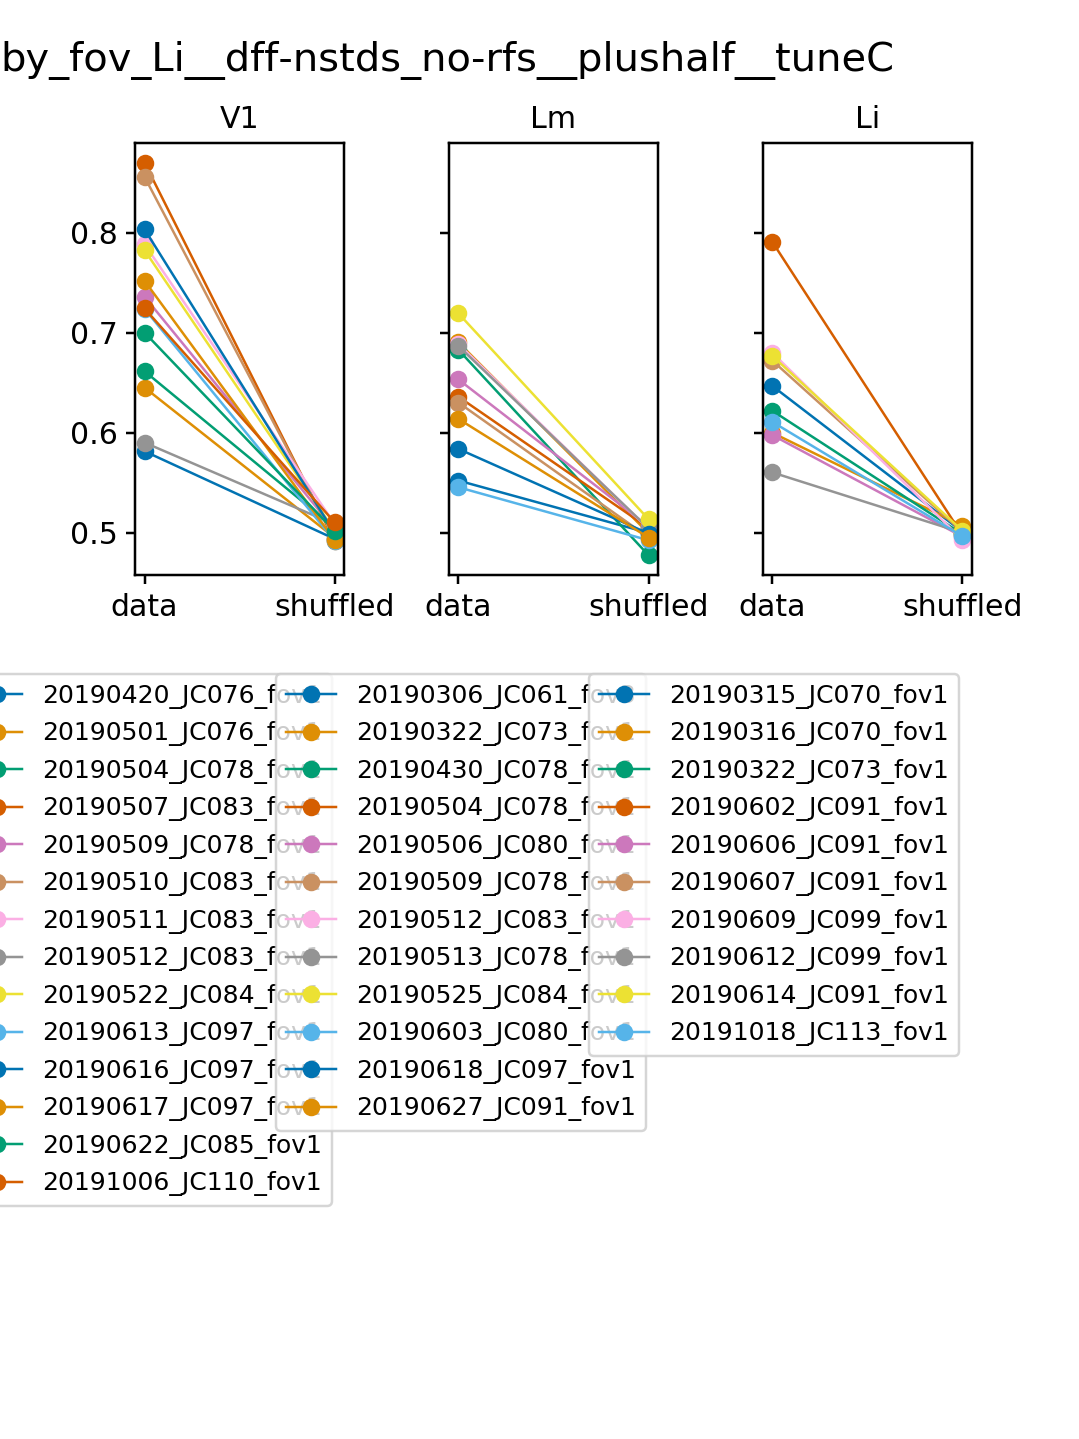

V1: (t-stat:9.52, p=0.00)
Lm: (t-stat:8.79, p=0.00)
Li: (t-stat:7.09, p=0.00)


In [27]:
if 'pupil' in analysis_type:
    currdf = plotdf[plotdf['arousal'].isin(['low', 'high'])]
    c1='low'
    c2='high'
    compare_var='arousal'
else:
    currdf = xdf.copy()
    c1='data'
    c2='shuffled'
    compare_var='condition'
    
    
    
curr_metric='heldout_test_score'
offset = 0.25
marker='o'

f, axn = pl.subplots(1,3, figsize=(6,8), sharey=True)

aix=0
for ai, visual_area in enumerate(visual_areas):
    ax=axn[ai]
    
    df_ = currdf[currdf['visual_area']==visual_area].copy()
    a_vals = df_[df_[compare_var]==c1].sort_values(by='datakey')[curr_metric].values
    b_vals = df_[df_[compare_var]==c2].sort_values(by='datakey')[curr_metric].values

    by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
    color_list = sns.color_palette('colorblind', n_colors=len(by_exp))
    labels = df_[df_[compare_var]==c1].sort_values(by='datakey')['datakey'].values
    
    for pi, (p, plabel) in enumerate(zip(by_exp, labels)):
        ax.plot([aix-offset, aix+offset], p, marker=marker, color=color_list[pi], 
                alpha=1, lw=1,  zorder=0, markerfacecolor=None, 
                markeredgecolor=color_list[pi], label=plabel)
        
    ax.set_xticks([aix-offset, aix+offset])
    ax.set_xticklabels([c1, c2])
    tstat, pval = spstats.ttest_rel(a_vals, b_vals)
    print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
    aix = aix+1
    ax.set_title(visual_area)
    
    ax.legend(bbox_to_anchor=(1, -0.2))

#     # Plot average
#     sns.barplot([0, 1], curr_metric, data=df_, 
#                 hue=compare_var, hue_order=[c1, c2], #zorder=0,
#                 ax=ax, #order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     #ax.legend_.remove()

# rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

f.text(0, 0.95, '%s' % results_id, fontsize=16)
pl.subplots_adjust(bottom=0.6, wspace=0.5, top=0.9)


# figname = 'paired_low-v-high_color-FOV_%s__%s' % (metric, C_str)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [166]:
currdf[(currdf['condition']=='data') & (currdf['visual_area']=='Li') & (currdf[metric]<=0.5)]

Empty DataFrame
Columns: [visual_area, datakey, condition, C, fit_time, heldout_MI, heldout_aMI, heldout_log2MI, heldout_test_score, score_time, test_score, train_score, n_cells, n_trials, iteration, fovnum]
Index: []

In [40]:
bds = glob.glob(os.path.join(rootdir, 'JC*', '2019*', '*%s' % fov_type, 'combined_blobs*', 
                            'traces', '%s*' % traceid, 'decoding', 'splitpupil*.pkl'))
bds

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/decoding/splitpupil_results_V1_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_dea723_traces001_8cef6c_traces001_abf256_traces001_fb7bfa_traces001_452942_traces001_c0afbd/decoding/splitpupil_results_Lm_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/decoding/splitpupil_results_Li_tuneC__dff-nstds.pkl',
 '/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/combined_b

In [37]:
rfile = bds[1]
with open(rfile, 'rb') as f:
    d = pkl.load(f)
d.groupby(['arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
arousal                                                               
all      0.02386  0.171685    0.170252     0.237016        0.245622   
high     0.03430  0.025259    0.084630     0.084727        0.122095   
low      0.03484  0.029401    0.080132     0.081467        0.115606   

         heldout_test_score  n_cells  n_trials  score_time  test_score  \
arousal                                                                  
all                0.776333      294       300    0.032981    0.758129   
high               0.664211      294        93    0.009571    0.637845   
low                0.676000      294       100    0.008663    0.702166   

         train_score  
arousal               
all         0.974251  
high        0.974595  
low         0.979818

In [36]:
d.groupby(['arousal']).mean()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
arousal                                                               
all      0.02962  0.070754    0.193766     0.271013        0.279545   
high     0.03142  0.013911    0.145102     0.179215        0.209338   
low      0.01180  0.015889    0.119079     0.141496        0.171794   

         heldout_test_score  n_cells  n_trials  score_time  test_score  \
arousal                                                                  
all                0.792069      136       290    0.021631    0.793375   
high               0.731000      136        97    0.005092    0.740175   
low                0.722857      136       102    0.006979    0.731188   

         train_score  
arousal               
all         0.917475  
high        0.967003  
low         0.949439

In [19]:
metric='heldout_test_score'
res[metric].mean(), res[metric].std()

(0.7258333333333333, 0.059429338210849815)

# Equal trial counts

In [69]:
trial_epoch = 'stimulus'
MEANS = aggr.load_aggregate_data(experiment, responsive_test=responsive_test, responsive_thr=responsive_thr, 
               response_type=response_type, epoch=trial_epoch)

MEANS = equal_counts_per_condition(MEANS)


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
20190512_JC083_fov1: n=31
20190606_JC091_fov1: n=32
20190605_JC090_fov1: n=32
20190602_JC091_fov1: n=29
20190508_JC083_fov1: n=29
20190617_JC097_fov1: n=29
20190430_JC078_fov1: n=29
20191006_JC110_fov1: n=33
20190617_JC099_fov1: n=19
20190513_JC078_fov1: n=29
20190502_JC076_fov1: n=26


In [66]:
len(curr_counts.unique())


3

# Classify A/B, by NCELLS

In [39]:
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(decoding_dir, 'by_ncells', '%s_iter*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-50_overlap-0.80_results_20200926.pkl']

In [95]:
dst_dir = os.path.join(decoding_dir, 'by_ncells')
os.listdir(dst_dir)

['traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl',
 'traintest_by-ncells_iter-500_overlap-0.80_params_20200926.json',
 'traintest_by-ncells_iter-500__heldout_test_scorezoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_test_score_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_log2MIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMI_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_iter-500__heldout_aMIzoom_overlap-thr=0.80_filter-repeat-fovs_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MI_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_log2MIzoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom_20200926.svg',
 'traintest_by-ncells_overlap-0.80_d

In [96]:
n_iterations = 500
overlap_thr=0.8
train_str = 'traintest_by-ncells' 
glob.glob(os.path.join(dst_dir, '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))
#glob.glob(os.path.join(dst_dir, '*overlap-%.2f_*.pkl' % (overlap_thr)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl']

In [97]:
results_dfile = glob.glob(os.path.join(dst_dir, 
                                      '%s_iter-%i_overlap-%.2f_*.pkl' % (train_str, n_iterations, overlap_thr)))[0]

# results_dfile = glob.glob(os.path.join(dst_dir, 
#                                        '*overlap-%.2f_*.pkl' % (overlap_thr)))[0]
#results_dfile = os.path.join(dst_dir, 'results_20200924.pkl')
# 'results_overlap-0.80.pkl' 200 cells, incoplete

with open(results_dfile, 'rb') as f:
    results = pkl.load(f)
if isinstance(results, dict):
    print(results.keys())
    results = results['pooled']
    #sdf = resultsdict['sdf']
else:
    results = results
    
results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
params_dfile = '%s.json' % os.path.splitext(results_dfile)[0].replace('results', 'params')
if os.path.exists(params_dfile):
    with open(params_dfile, 'r') as f:
        params = json.load(f)
    print("Train/test params for %s:" % train_str)
    pp.pprint(params)
else:
    print("No params")
print("File basename: %s" % results_basename)

['pooled']
Train/test params for traintest_by-ncells:
{   u'C_value': None,
    u'cv': True,
    u'cv_nfolds': 5,
    u'n_iterations': 500,
    u'overlap_thr': 0.8,
    u'test_split': 0.2}
File basename: traintest_by-ncells_iter-500_overlap-0.80_results_20200926


In [98]:
results.keys()

Index([u'C', u'C_sem', u'C_std', u'fit_time', u'fit_time_sem', u'fit_time_std',
       u'heldout_MI', u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_precision_macro', u'test_precision_macro_sem',
       u'test_precision_macro_std', u'test_recall_macro',
       u'test_recall_macro_sem', u'test_recall_macro_std', u'train_accuracy',
       u'train_accuracy_sem', u'train_accuracy_std', u'train_precision_macro',
       u'train_precision_macro_sem', u'train_precision_macro_std',
       u'train_recall_macro', u'train_recall_macro_sem',
       u'train_recall_macro_std', u'visual_area'],
      dtype='object')

In [99]:
date_str = results_basename.split('_')[-1]
plot_str = '_test_%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)
print(plot_str)
print(date_str)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly
_test_traintest_by-ncells_overlap-0.80
20200926


In [100]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

<IPython.core.display.Javascript object>


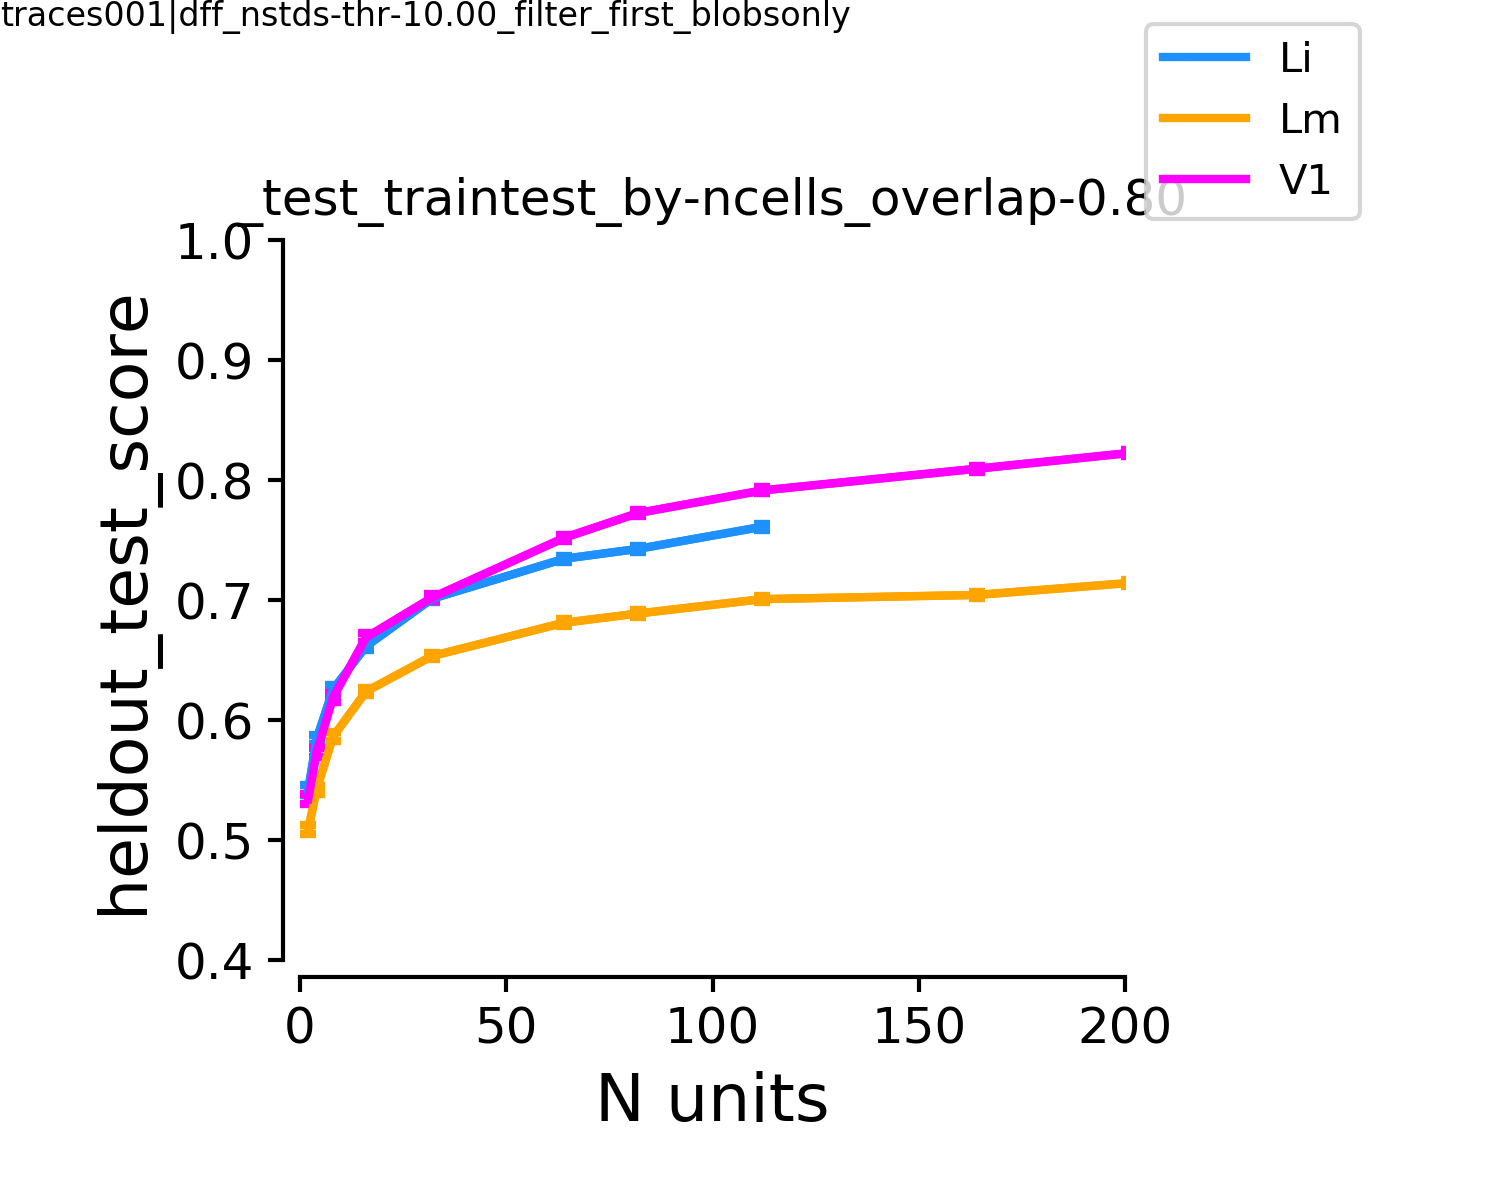

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_scorezoom')


<IPython.core.display.Javascript object>


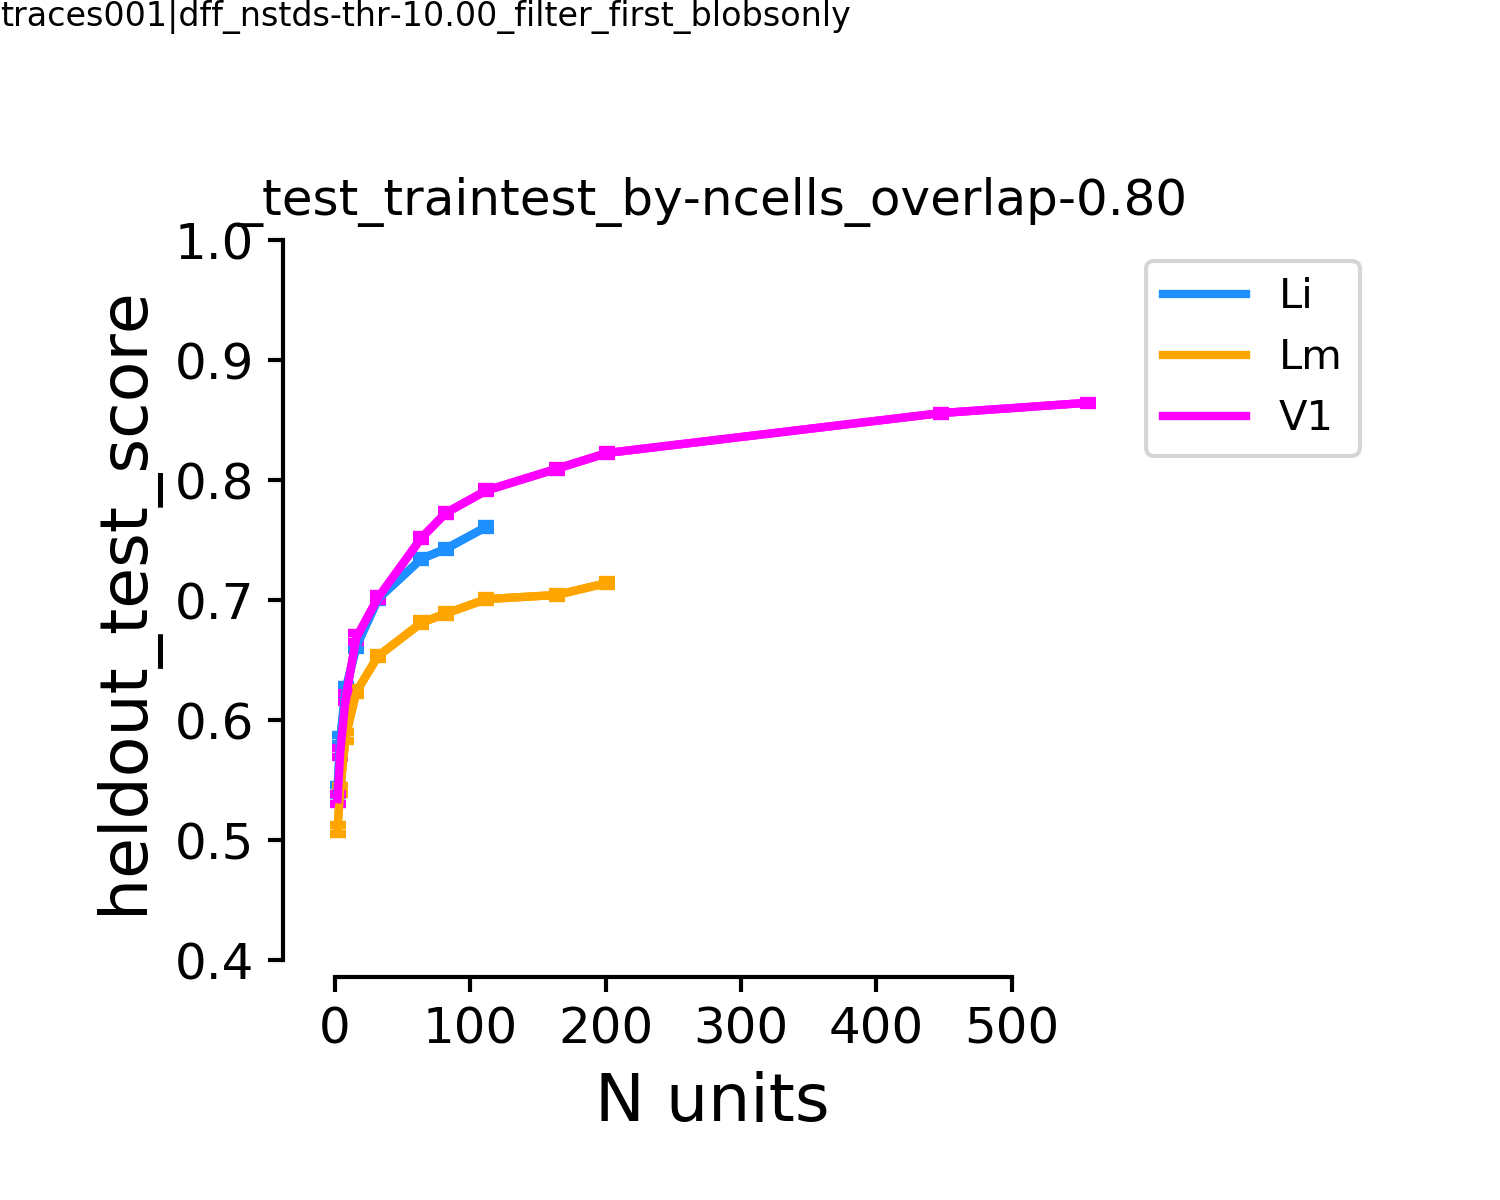

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', '_test_traintest_by-ncells_overlap-0.80_decode_heldout_test_score')


In [101]:
metric = 'heldout_test_score'
dutils.default_classifier_by_ncells(results, metric=metric, plot_str=plot_str, date_str=date_str,
                                    dst_dir=dst_dir, data_id=data_id, area_colors=area_colors, xlim=200)
                                    

# Test Generalization -- size

In [60]:
n_train_configs=4
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'match_RF_overlap', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap/train-4_sample-112_iter-100_results.pkl']

In [65]:
overlap_dir = os.path.join(decoding_dir, 'match_RF_overlap')
results_dfile = glob.glob(os.path.join(overlap_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-4_sample-112_iter-100_results


In [12]:
animalid = 'JC097'
session = '20190616'
fovnum = 1
exp = util.Objects(animalid, session, 'FOV%i_zoom2p0x' % fovnum, traceid=traceid)
sdf = exp.get_stimuli()


In [67]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


In [71]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


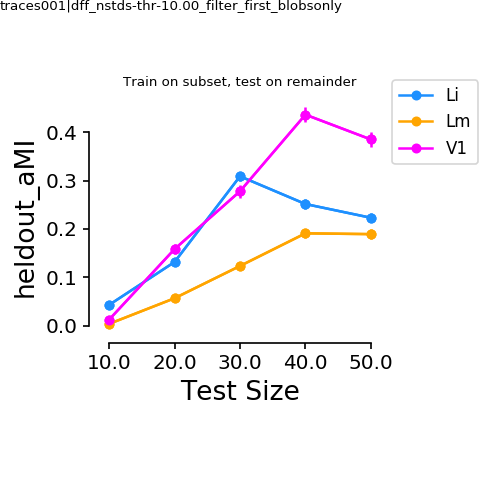

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


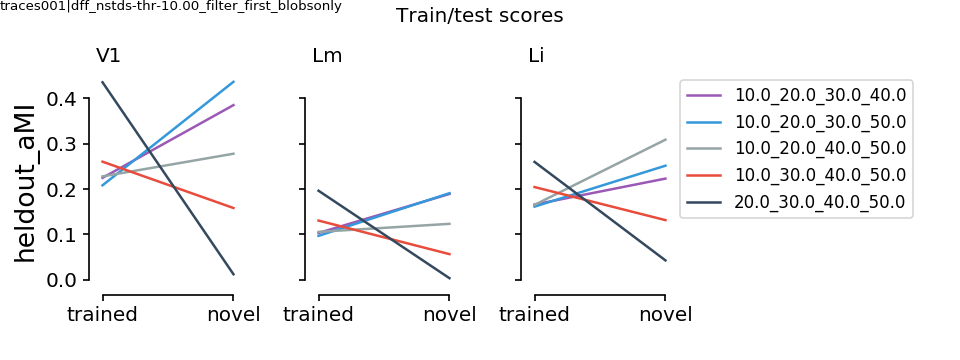

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


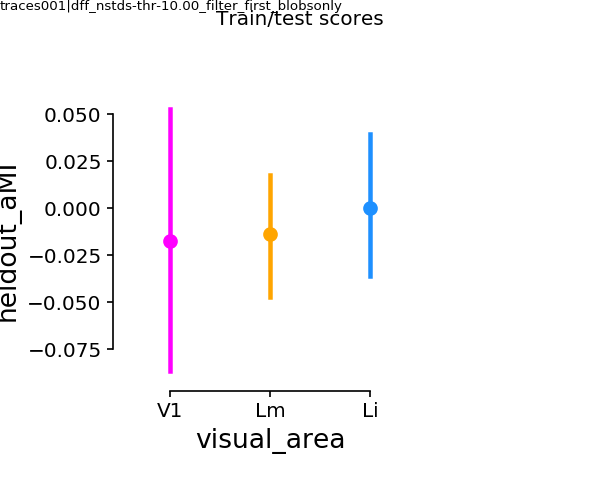

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [73]:
metric = 'heldout_aMI'
dutils.default_train_test_subset(results, sdf, metric=metric, area_colors=area_colors, 
                                 plot_str=plot_str, data_id=data_id, dst_dir=overlap_dir)


In [77]:
results.head()

C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
0  0.010  0.002216    0.055217     0.065015        0.079662   
1  0.010  0.002216    0.167874     0.232338        0.242191   
2  0.001  0.002637    0.134455     0.180996        0.193977   
3  0.001  0.002637    0.062245     0.077773        0.089801   
4  0.010  0.002267    0.153134     0.208435        0.220926   

   heldout_test_score  score_time  test_accuracy  test_precision_macro  \
0            0.659574    0.002186       0.773052              0.780050   
1            0.758621    0.002186       0.773052              0.780050   
2            0.744681    0.002641       0.696989              0.728557   
3            0.637931    0.002641       0.696989              0.728557   
4            0.765957    0.002227       0.675786              0.691301   

   test_recall_macro       test_transform  train_accuracy  \
0           0.773099  10.0_20.0_30.0_40.0        0.878349   
1           0.773099                 50.0        0.878349   
2           0.698246  10.0_20.0_30.0_50.0        0.772837   
3           0.698246                 40.0        0.772837   
4           0.675439  10.0_20.0_40.0_50.0        0.850086   

   train_precision_macro  train_recall_macro      train_transform  iteration  \
0               0.878713            0.878306  10.0_20.0_30.0_40.0          0   
1               0.878713            0.878306  10.0_20.0_30.0_40.0          0   
2               0.806416            0.773706  10.0_20.0_30.0_50.0          0   
3               0.806416            0.773706  10.0_20.0_30.0_50.0          0   
4               0.851258            0.850153  10.0_20.0_40.0_50.0          0   

   n_units visual_area  overlap  
0      112          Li      0.8  
1      112          Li      0.8  
2      112          Li      0.8  
3      112          Li      0.8  
4      112          Li      0.8

# Test generalization - 1 size

In [83]:
n_train_configs=1
n_iterations = 100
sample_ncells=112
train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-1_test-1', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1/train-1_sample-112_iter-100_results.pkl']

In [84]:
dst_dir = os.path.join(decoding_dir, 'train-1_test-1')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[0]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-1_sample-112_iter-100_results


In [85]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


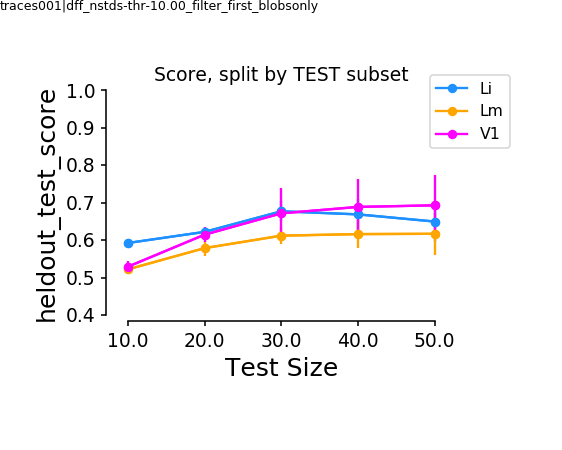

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-test-size')


In [468]:
metric = 'heldout_test_score'
testdf = pd.concat([g[g['test_transform']!=train].groupby(['visual_area', 'test_transform']).mean() \
           for (visual_area, train), g in results.groupby(['visual_area', 'train_transform'])]).reset_index()


fig, ax = pl.subplots(figsize=(5,4), dpi=150)
# dutils.plot_scores_by_test_set(results, sdf, metric=metric, area_colors=area_colors, ax=ax, plot_sem=True)

sizes = [str(s) for s in sdf['size'].unique()]
markersize=5
for visual_area, vdf in testdf.groupby(['visual_area']):
    #for train, traindf in vdf.groupby(['train_transform']):
    mean_vals = vdf.groupby(['test_transform']).mean()[metric]
    sem_vals = vdf.groupby(['test_transform']).sem()[metric]

    ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=visual_area)
    ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
               marker='o', markersize=markersize, label=None)

    ax.set_xticks(np.arange(0, len(sizes)))
    ax.set_xticklabels(sizes)

ax.set_xlabel('Test Size', fontsize=16)
ax.set_ylabel(metric, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)

ax.legend(bbox_to_anchor=(1.2, 1.1))

if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1])
else:
    ax.set_ylim([0, 0.4])
sns.despine(trim=True,offset=4)

putils.label_figure(fig, data_id)
ax.set_title("Score, split by TEST subset")

figname = '%s_%s_by-test-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [385]:
sizes = sdf['size'].unique()

#### Relative score

In [517]:
subtract_novel=True
metric = 'heldout_test_score'

metric_names = [p for p in results.columns if 'heldout' in p or 'C' in p]
mean_results=results.groupby(['visual_area', 'train_transform', 'test_transform']).mean()[metric_names].reset_index()

relative_df = pd.concat([pd.DataFrame({
                          'trained': [float(g[g['test_transform']==train][metric].values) for _ in np.arange(0, len(g)-1)],
                          'novel': g[g['test_transform']!=train][metric],
                          'visual_area': [visual_area for _ in np.arange(0, len(g)-1)], 
                          'train_transform': [train for _ in np.arange(0, len(g)-1)], 
                          'test_transform': g[g['test_transform']!=train]['test_transform']}) \
             for (visual_area,train), g in mean_results.groupby(['visual_area', 'train_transform'])])

if subtract_novel:
    relative_df['relative_%s' % metric] = (relative_df['trained'] - relative_df['novel']) #/ relative_df['trained']
else:
    relative_df['relative_%s' % metric] = (relative_df['novel'] - relative_df['trained']) #/ relative_df['trained']

relative_str='subtract-novel' if subtract_novel else 'subtract-trained'

<IPython.core.display.Javascript object>


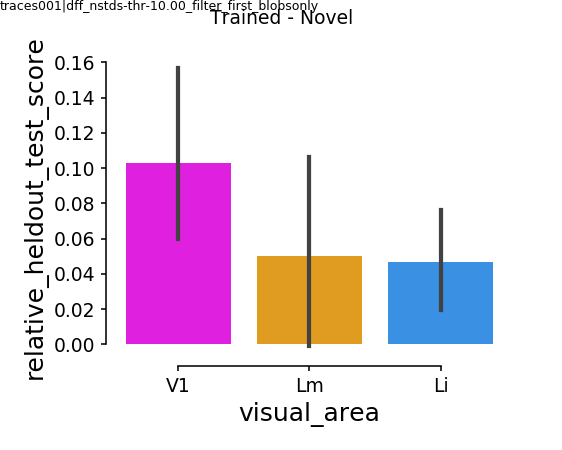

********* [relative_heldout_test_score] Mann-Whitney U test(mc=holm) **********
[('V1', 'Lm')] p=0.115 (holm), reject H0=False
[('V1', 'Li')] p=0.115 (holm), reject H0=False
[('Lm', 'Li')] p=0.299 (holm), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_avg-novel-v-trained_relative_heldout_test_score_subtract-novel')


In [518]:
fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
sns.barplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
           order=visual_areas, palette=area_colors)
#sns.stripplot(x='visual_area', y='relative_%s' % metric, data=relative_df, ax=ax,
#            hue='test_transform', palette='colorblind', order=visual_areas, dodge=True)
statresults, ax = aggr.plot_mannwhitney(relative_df, metric='relative_%s' % metric, multi_comp_test='holm', ax=ax)
sns.despine(trim=True, offset=4)

pl.subplots_adjust(left=0.2, right=0.9, bottom=0.2)

putils.label_figure(fig, data_id)


if subtract_novel:
    fig.suptitle('Trained - Novel')
else:
    fig.suptitle('Novel - Trained')

figname = '%s_avg-novel-v-trained_relative_%s_%s' % (plot_str, metric, relative_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


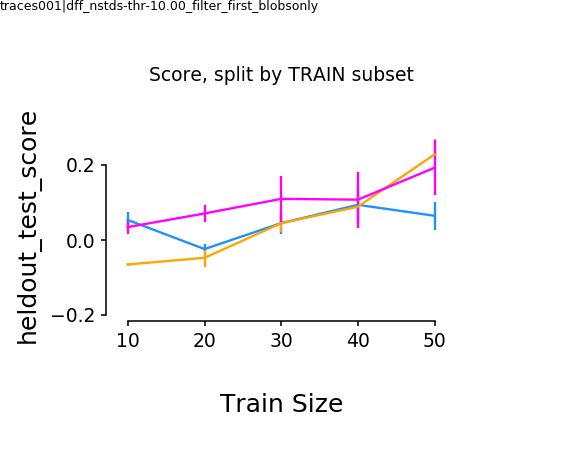

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_by-train-size')


In [465]:
# Plot.

sizes = sdf['size'].unique()

fig, ax = pl.subplots(1, dpi=dpi, figsize=(5,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    
    mean_vals = vdf.groupby(['train_transform']).mean()['relative_%s' % metric]
    sem_vals = vdf.groupby(['train_transform']).sem()['relative_%s' % metric]
    xv = sizes
    
    ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

    #ax.axhline(y=0.5, color='k', linestyle=':')
    #ax.set_ylim([0.4, 1])
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(s) for s in sizes])
    
ax.set_ylim([-0.2, 0.4])
fig.text(0.5, 0.1, 'Train Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)


putils.label_figure(fig, data_id)

ax.set_title("Score, split by TRAIN subset")
figname = '%s_%s_by-train-size' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [479]:
reldf.head()

heldout_log2MI  iteration visual_area  train_transform  test_transform
0             0.0          0          Li             10.0            10.0
1             0.0          1          Li             10.0            10.0
2             0.0          2          Li             10.0            10.0
3             0.0          3          Li             10.0            10.0
4             0.0          4          Li             10.0            10.0

<IPython.core.display.Javascript object>


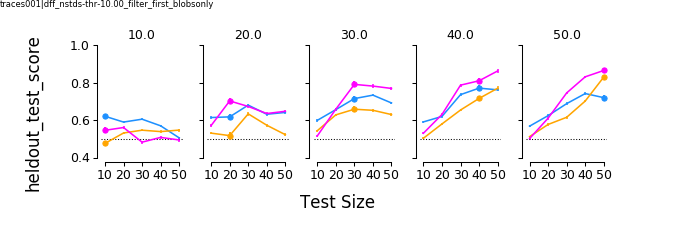

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform')


In [480]:
# Plot.

metric = 'heldout_test_score'

fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)
sizes = sdf['size'].unique()

marker='o'
markersize=5
for ax, (train_transform, traindf) in zip(axn.flat, results.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])
        train_ix = list(sizes).index(train_transform)
        
        ax.errorbar(xv[train_ix], mean_vals.loc[train_transform], yerr=sem_vals.loc[train_transform],
                 marker=marker,markersize=markersize, color=area_colors[visual_area])
        
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
        
    if metric =='heldout_test_score':
        ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, linestyle=':', color='k', lw=1)
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

figname = '%s_%s_split-train-test-transform' % (plot_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [481]:
print(metric)

heldout_test_score


In [87]:
test_minus_train=True
sizes = sdf['size'].unique()

metric = 'heldout_test_score'
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            #rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            if test_minus_train:
                rel_scores = (curr_test_vals - curr_train_vals) #* curr_train_vals
            else:
                rel_scores = (curr_train_vals - curr_test_vals) #* curr_train_vals
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
reldf = pd.concat(r_list, axis=0).reset_index(drop=True) 

<IPython.core.display.Javascript object>


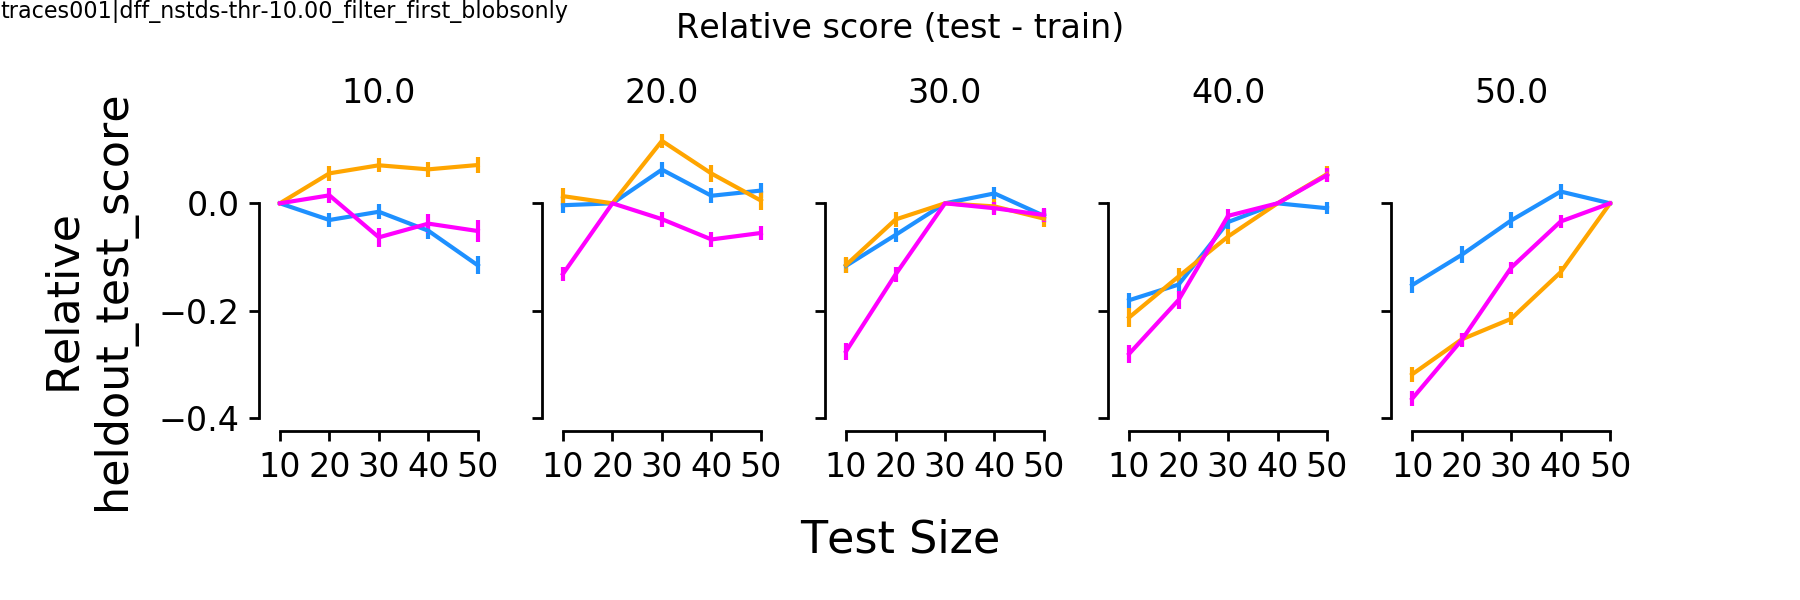

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-1_test-1', 'train-1_sample-112_iter-100_overlap-0.80_heldout_test_score_split-train-test-transform_RELATIVE-subtract-train')


In [89]:
fig, axn = pl.subplots(1, 5, figsize=(9,3), sharey=True, sharex=False)

for ax, (train_transform, traindf) in zip(axn.flat, reldf.groupby(['train_transform'])):
    
    for visual_area, vdf in traindf.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).sem()[metric]
#         xv = vdf[vdf['test_transform']!=train_transform].groupby(['test_transform']).mean().index.values
        mean_vals = vdf.groupby(['test_transform']).mean()[metric]
        sem_vals = vdf.groupby(['test_transform']).sem()[metric]
        xv = vdf.groupby(['test_transform']).mean().index.values

        ax.errorbar(xv, mean_vals, yerr=sem_vals, color=area_colors[visual_area])

        #ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(xv)
        ax.set_xticklabels([int(s) for s in xv])
    
        ax.set_title(train_transform)
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, 'Relative\n%s' % metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.15, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)
putils.label_figure(fig, data_id)

if test_minus_train:
    fig.suptitle('Relative score (test - train)')
else:
    fig.suptitle('Relative score (train - test)')

relative_calc = 'subtract-train' if test_minus_train else 'subtract-test'

figname = '%s_%s_split-train-test-transform_RELATIVE-%s' % (plot_str, metric, relative_calc)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [371]:
train_str

'train-1_sample-112_iter-100'

In [372]:
plot_str

'train-1_sample-112_iter-100_overlap-0.80'

In [373]:
fig_str

'dff_nstds-thr-10.00_filter_first_blobsonly'

# Morphs

In [8]:
n_iterations = 100
sample_ncells=112
train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)  

overlap_thr=0.8
glob.glob(os.path.join(decoding_dir, 'train-anchors', '%s*.pkl' % (train_str)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results_1.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl']

In [9]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')
results_dfile = glob.glob(os.path.join(dst_dir, '%s*.pkl' % (train_str)))[1]
with open(results_dfile, 'rb') as f:
    results = pkl.load(f)

results_basename = os.path.splitext(os.path.split(results_dfile)[-1])[0]
print("File basename: %s" % results_basename)

File basename: train-anchors-split-size_sample-112_iter-100_results2


In [10]:
plot_str = '%s_overlap-%.2f' % (train_str, overlap_thr)
fig_str = '%s_%s' % (response_str, filter_str)
data_id = '%s|%s' % (traceid, fig_str)
print(data_id)

traces001|dff_nstds-thr-10.00_filter_first_blobsonly


<IPython.core.display.Javascript object>


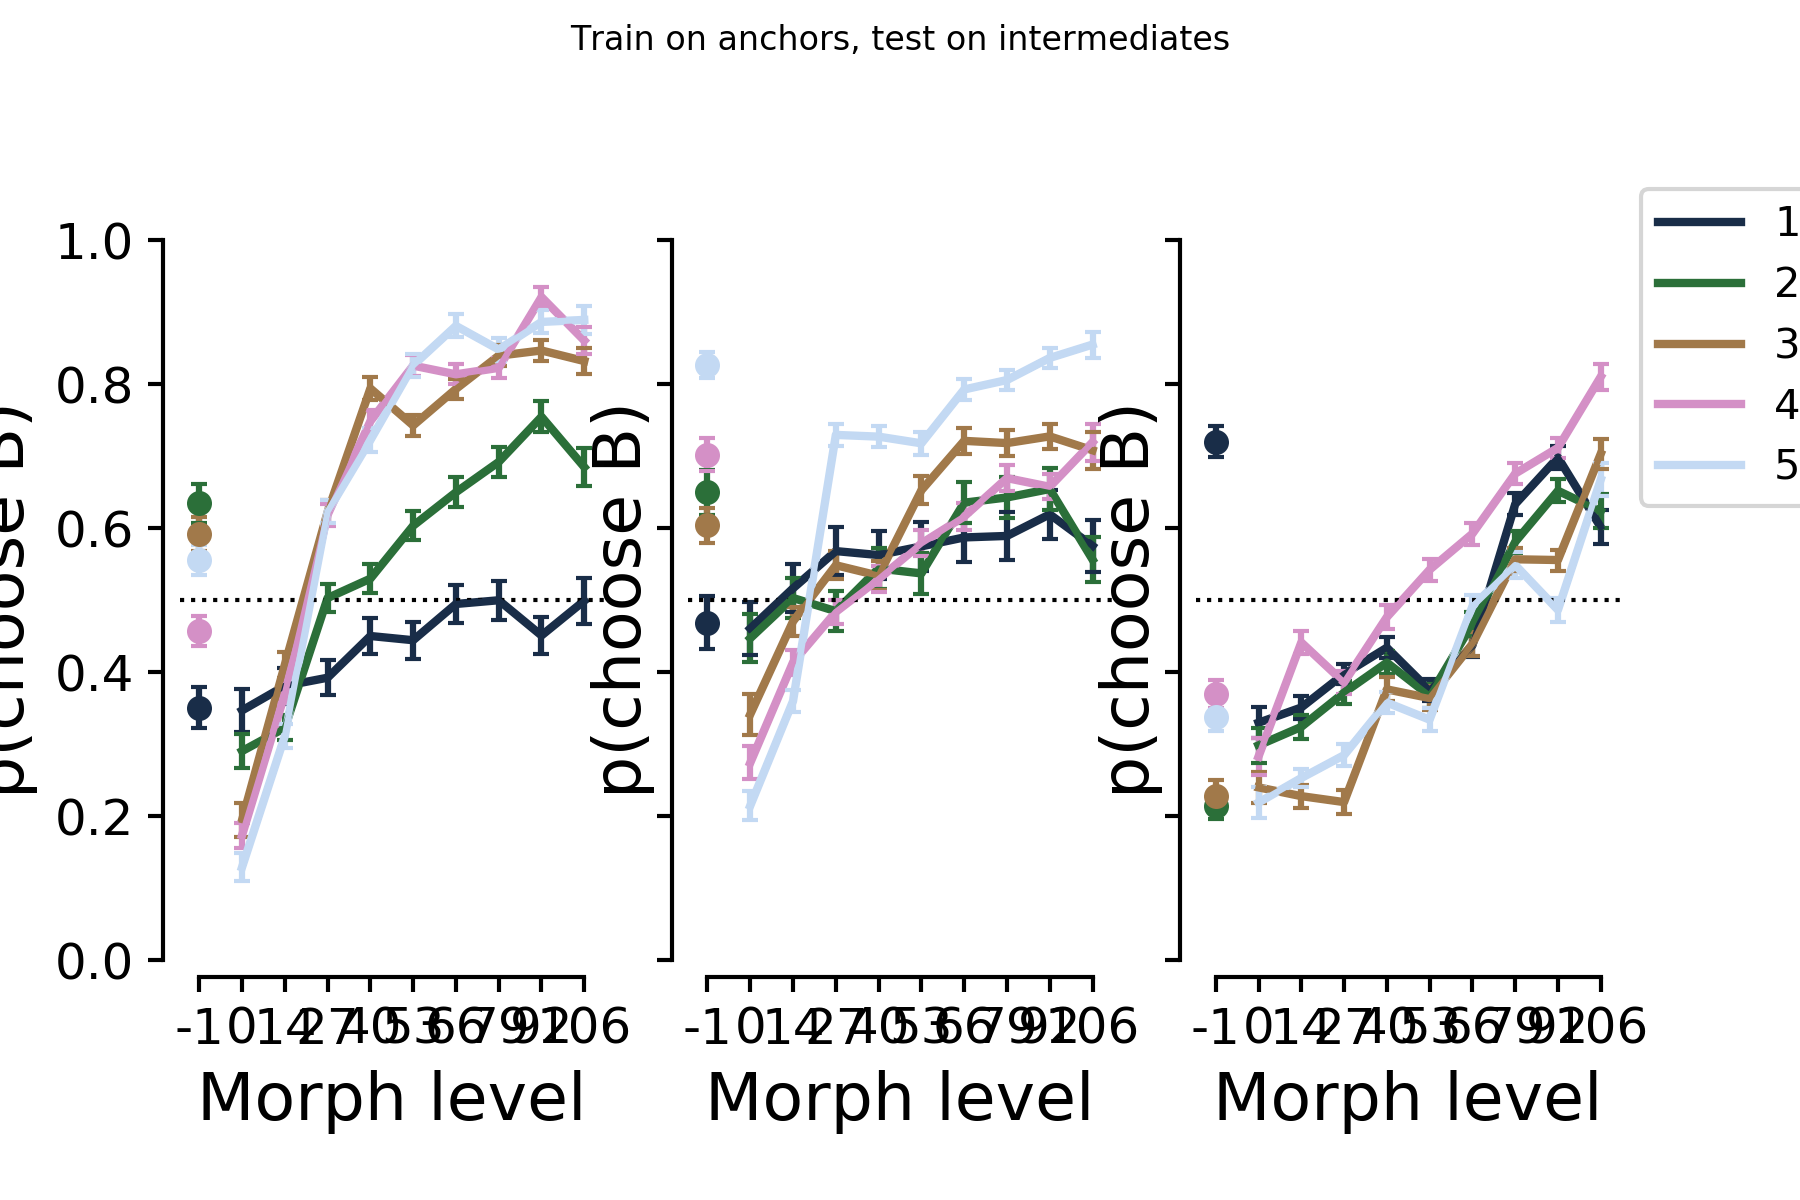

Text(0.5,0.98,u'Train on anchors, test on intermediates')

In [32]:
hue_size = True
col_name = 'morphlevel'
markersize=5
capsize=2
lw=2
alpha = 1

fig, axn = pl.subplots(1, 3, figsize=(6,4), sharex=True, sharey=True, dpi=150)
alphas = np.linspace(0.1, 1, 5)
ci = 95
shade=False
plot_ci=False
plot_luminance= True

plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

for visual_area, vdf in results.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    size_colors = sns.color_palette('cubehelix', n_colors=5)
    
    for si, (sz, df_) in enumerate(vdf.groupby(['size'])):
        morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
        xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
        
        curr_color = size_colors[si] if hue_size else area_colors[visual_area]
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=curr_color,
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=curr_color, lw=lw, alpha=alpha, label=sz)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=curr_color,
                          capsize=capsize, alpha=alpha, label=None)
        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance \
                    else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    
    ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

    if ai==2:
        ax.legend(bbox_to_anchor=(1, 1.1))                               

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates", fontsize=8)


In [35]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


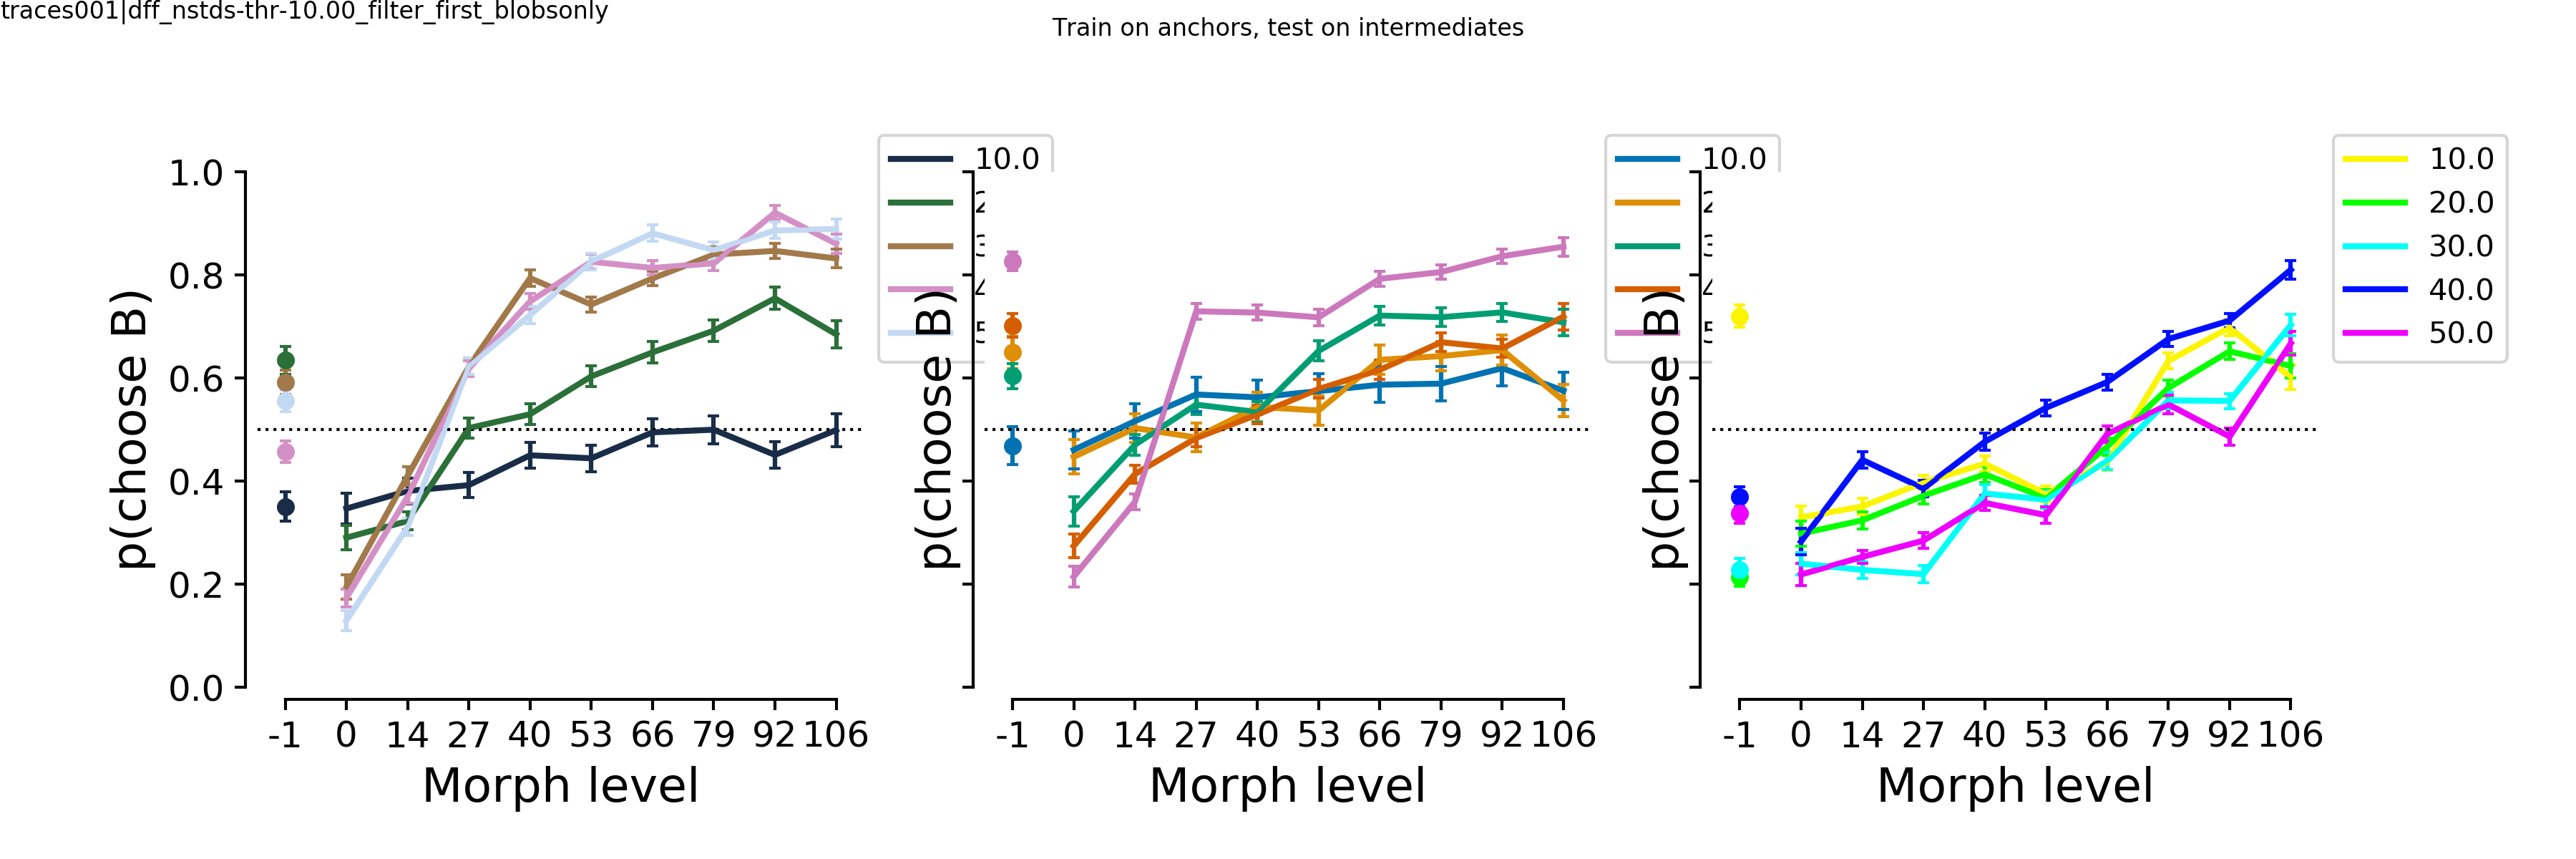

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_morphcurves_split-size__wLum')


In [36]:
dutils.default_morphcurves_split_size(results, sdf, area_colors=area_colors, dst_dir=dst_dir, data_id=data_id,
                                    lw=lw, train_str=train_str, capsize=2, hue_size=True)